THE SCHEDULING PROBLEM

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [6]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 2
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
#M = 1
#J = 2
#E = [(0,1)]
#run_times = np.array([1,1])
####

#### TEST 2 - 18 qubits PASSED
#M = 2
#J = 2
#E = [(1,0), (2,1)]
#run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = seperate_index_full_values_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.seperate_index_full_values_scheduling_problem'>
Used 8 qubits


In [7]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue_sparse(eigenvector, H_sparse):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return H_sparse.reshape((-1)).dot(eigenvector ** 2) #np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [8]:
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")
#get_expectation_value(state, op)  ###np.round(state.expectation_value(H_total_JSP).real, 10) (from: hamiltonians) state:Statevector

Extract diagonal kronker
Finish 0.2s
Find mininum eigenvalue (numpy min)
Finish 0.0s
Minimum Eigenvalue: 1.0
===Problem===
Run 1(+1 dummy) jobs on 2 machines.
Job Lengths: [1]
Dependency Graph [(0, 1)]
===
Quantum State (computational basis): |01000001>
===Solution===
t=0: Job #0 -> Machine #1
t=1: Job #dummy -> Machine #1
===end===


In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from hamiltonians import get_expectation_value

def initialize_circuit_from_string(state_string):
    # Create a quantum circuit with the appropriate number of qubits
    n = len(state_string)
    qc = QuantumCircuit(n)

    # Initialize the state vector
    state_vector = np.array([1])  # Start with the identity state |0⟩

    for char in state_string:
        if char == '0':
            state_vector = np.kron(state_vector, np.array([1, 0]))  # |0⟩
        elif char == '1':
            state_vector = np.kron(state_vector, np.array([0, 1]))  # |1⟩
        elif char == '+':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  # |+⟩
        elif char == '-':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), -1/np.sqrt(2)]))  # |-⟩
        else:
            raise ValueError(f"Invalid character '{char}' in state string. Use 0, 1, +, or -.")

    # Initialize the quantum circuit with the state vector
    qc.initialize(state_vector, range(n))

    return qc

def initialize_state_from_string(state_string):
    return Statevector.from_instruction(initialize_circuit_from_string(state_string))


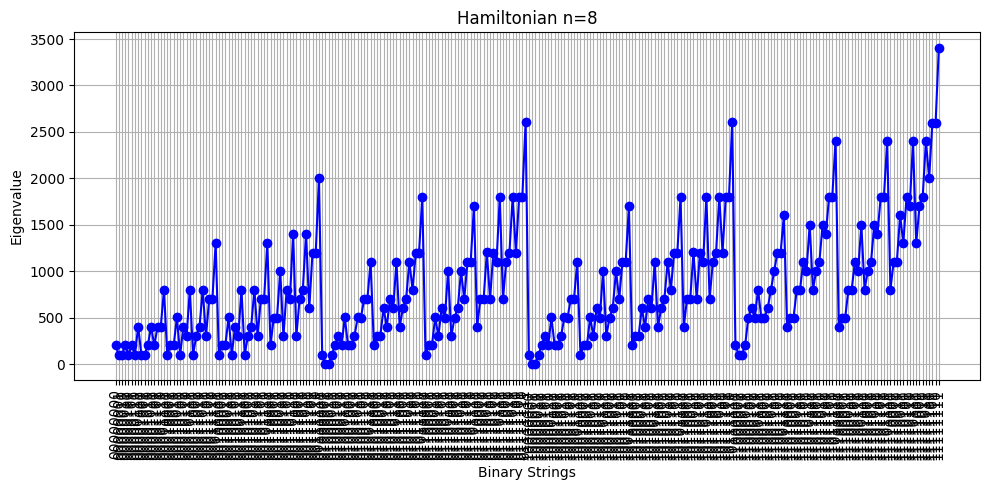

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def foo(binary_string):
    # Example function: count the number of '1's in the binary string
    return get_expectation_value(initialize_state_from_string(binary_string), H_total_JSP)

def generate_binary_strings(n):
    total_strings = 2 ** n
    binary_strings = []
    
    for i in range(total_strings):
        binary_string = format(i, '0' + str(n) + 'b')
        binary_strings.append(binary_string)
    
    return binary_strings

def create_heatmap(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros((2**n, 1))  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Reshape values for heatmap (1D to 2D)
    heatmap_data = values.reshape((2**n, 1))

    # Plotting the heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Function Value')
    plt.title(f'Heatmap of the eigenvalues n={n}')
    plt.xticks([])  # Hide x ticks
    plt.yticks(range(2**n), binary_strings)  # Show binary strings on y-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Function Values')
    plt.show()

def create_2d_graph(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros(2 ** n)  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Create x values (indices of binary strings)
    x_values = np.arange(len(binary_strings))

    # Plotting the 2D graph
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')
    plt.xticks(x_values, binary_strings, rotation=90)  # Show binary strings on x-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Eigenvalue')
    plt.title(f'Hamiltonian n={n}')
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    ax = plt.gca()
    #ax.set_ylim([-1000, 0])
    plt.show()

# Example usage
create_2d_graph(task.num_qubits)


In [12]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

attempting all MUB states over the operator JSP Problem
Energy Landscape:


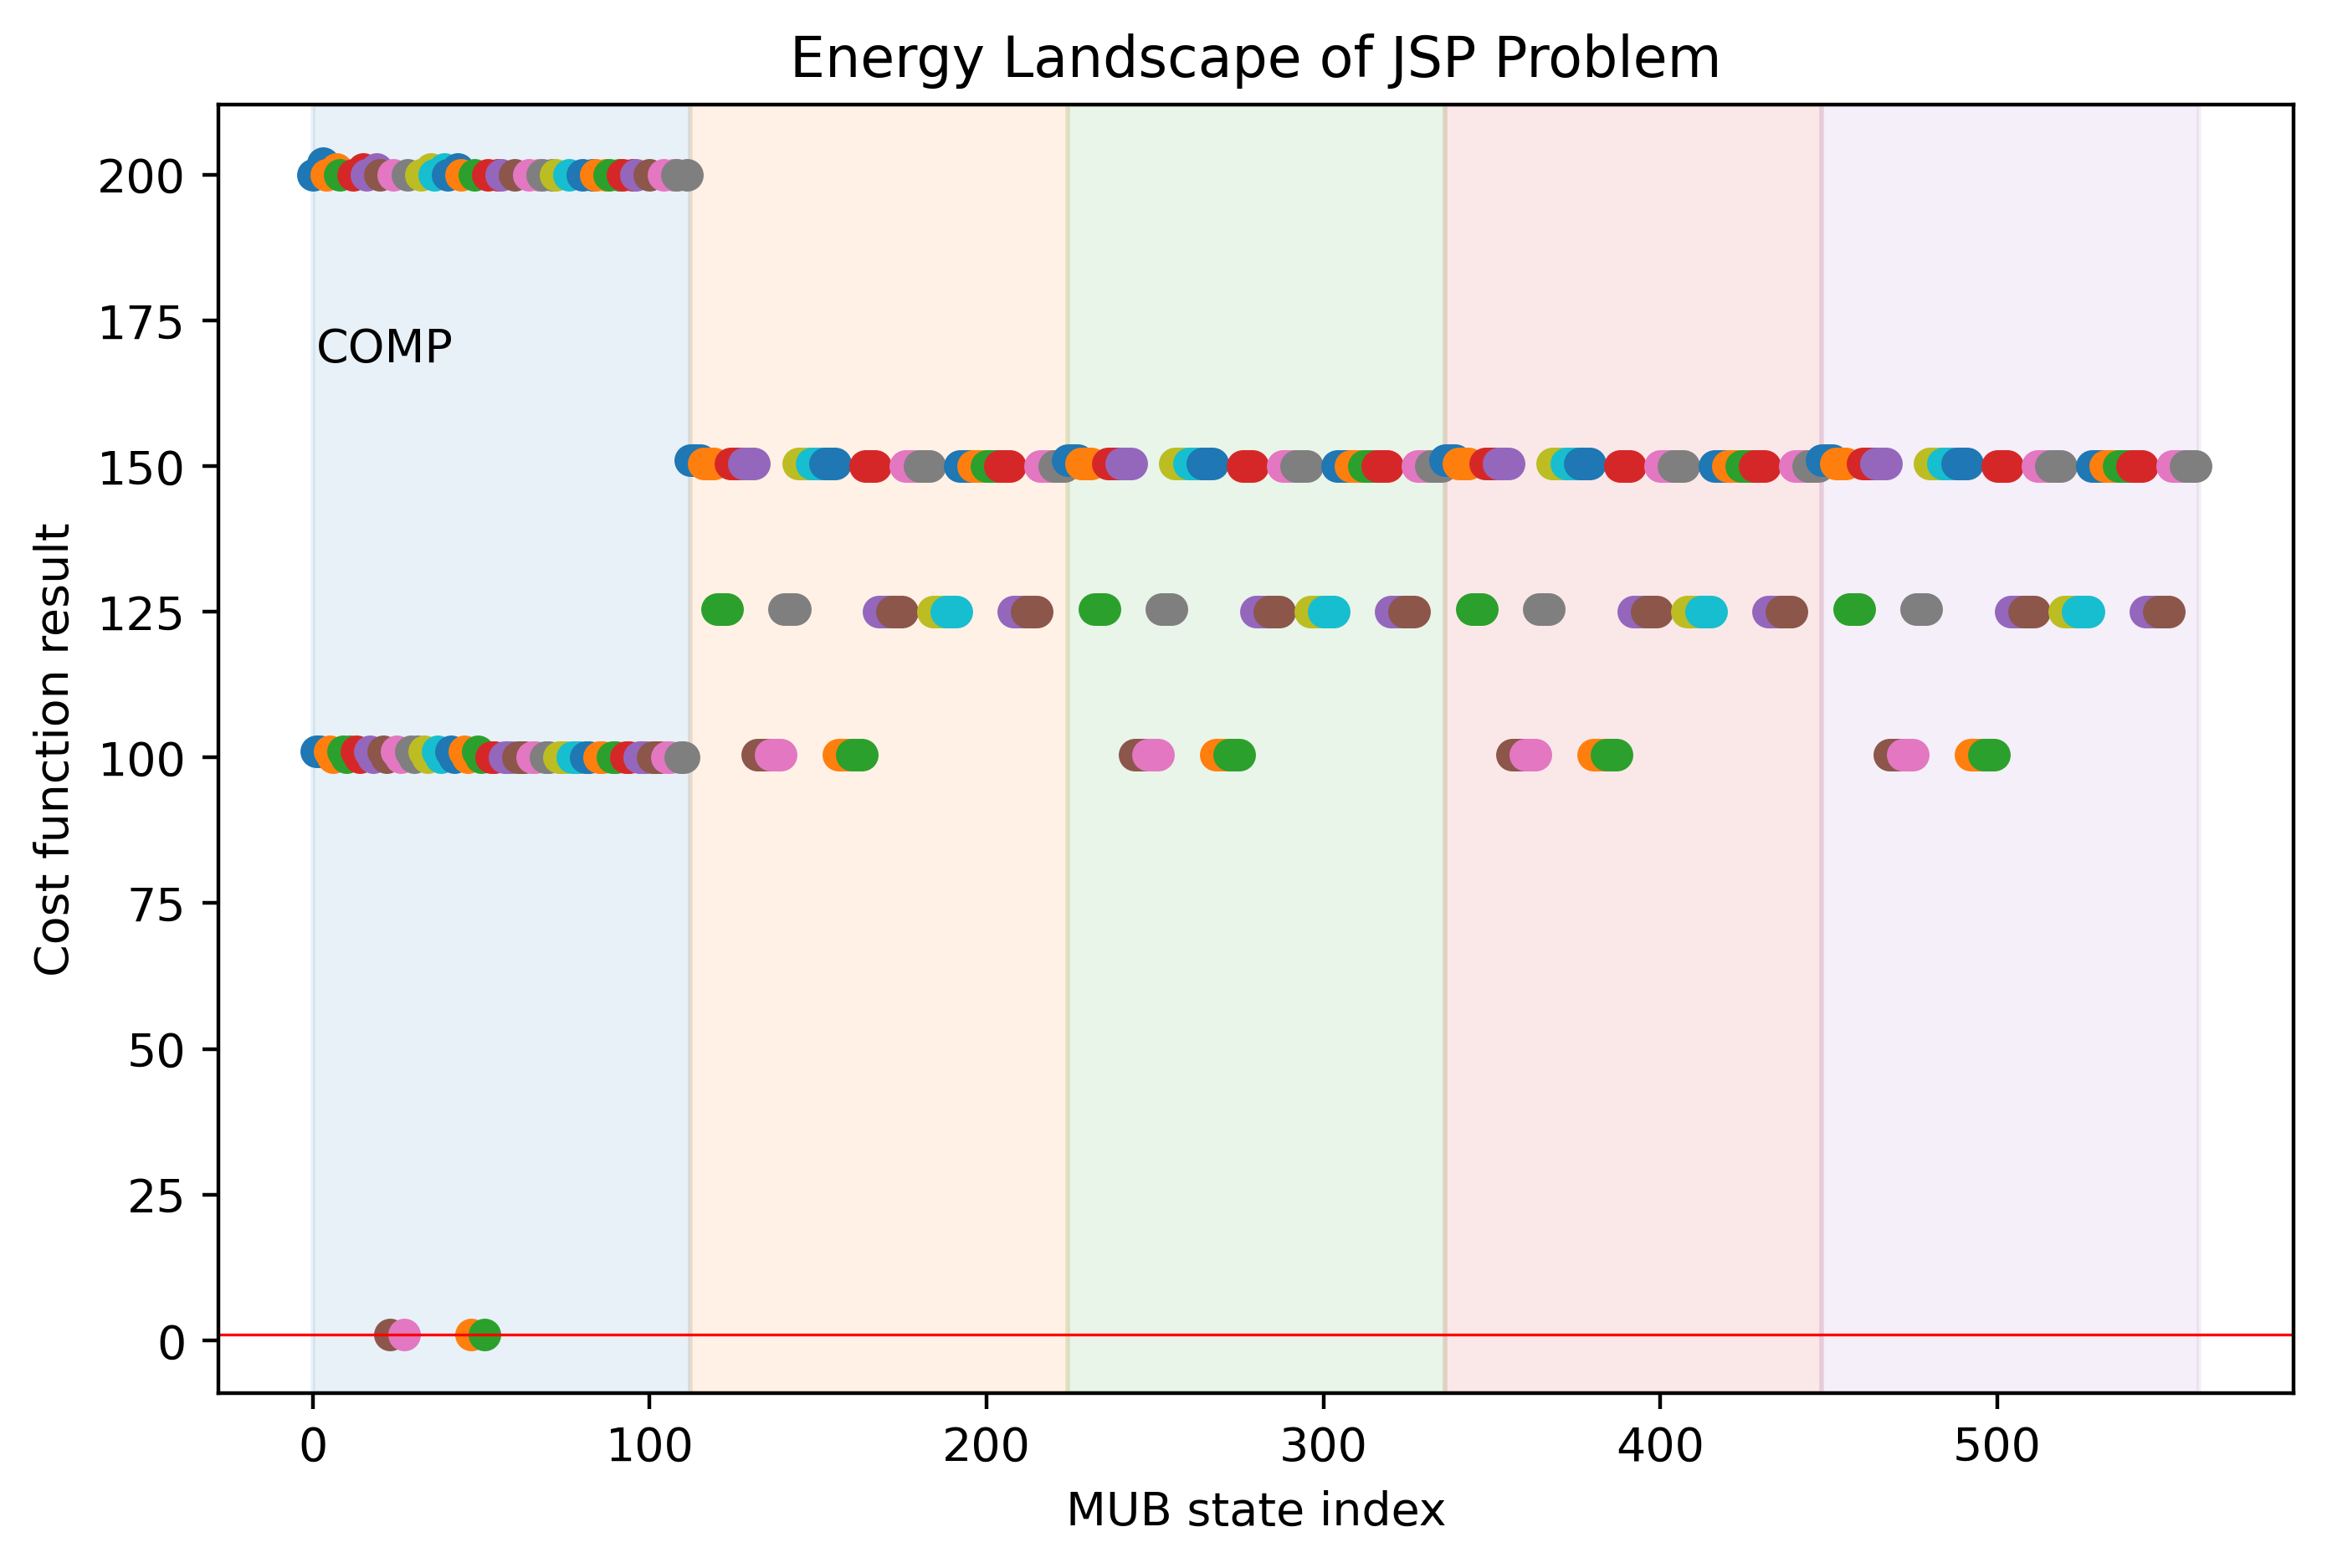

Energy Histogram:


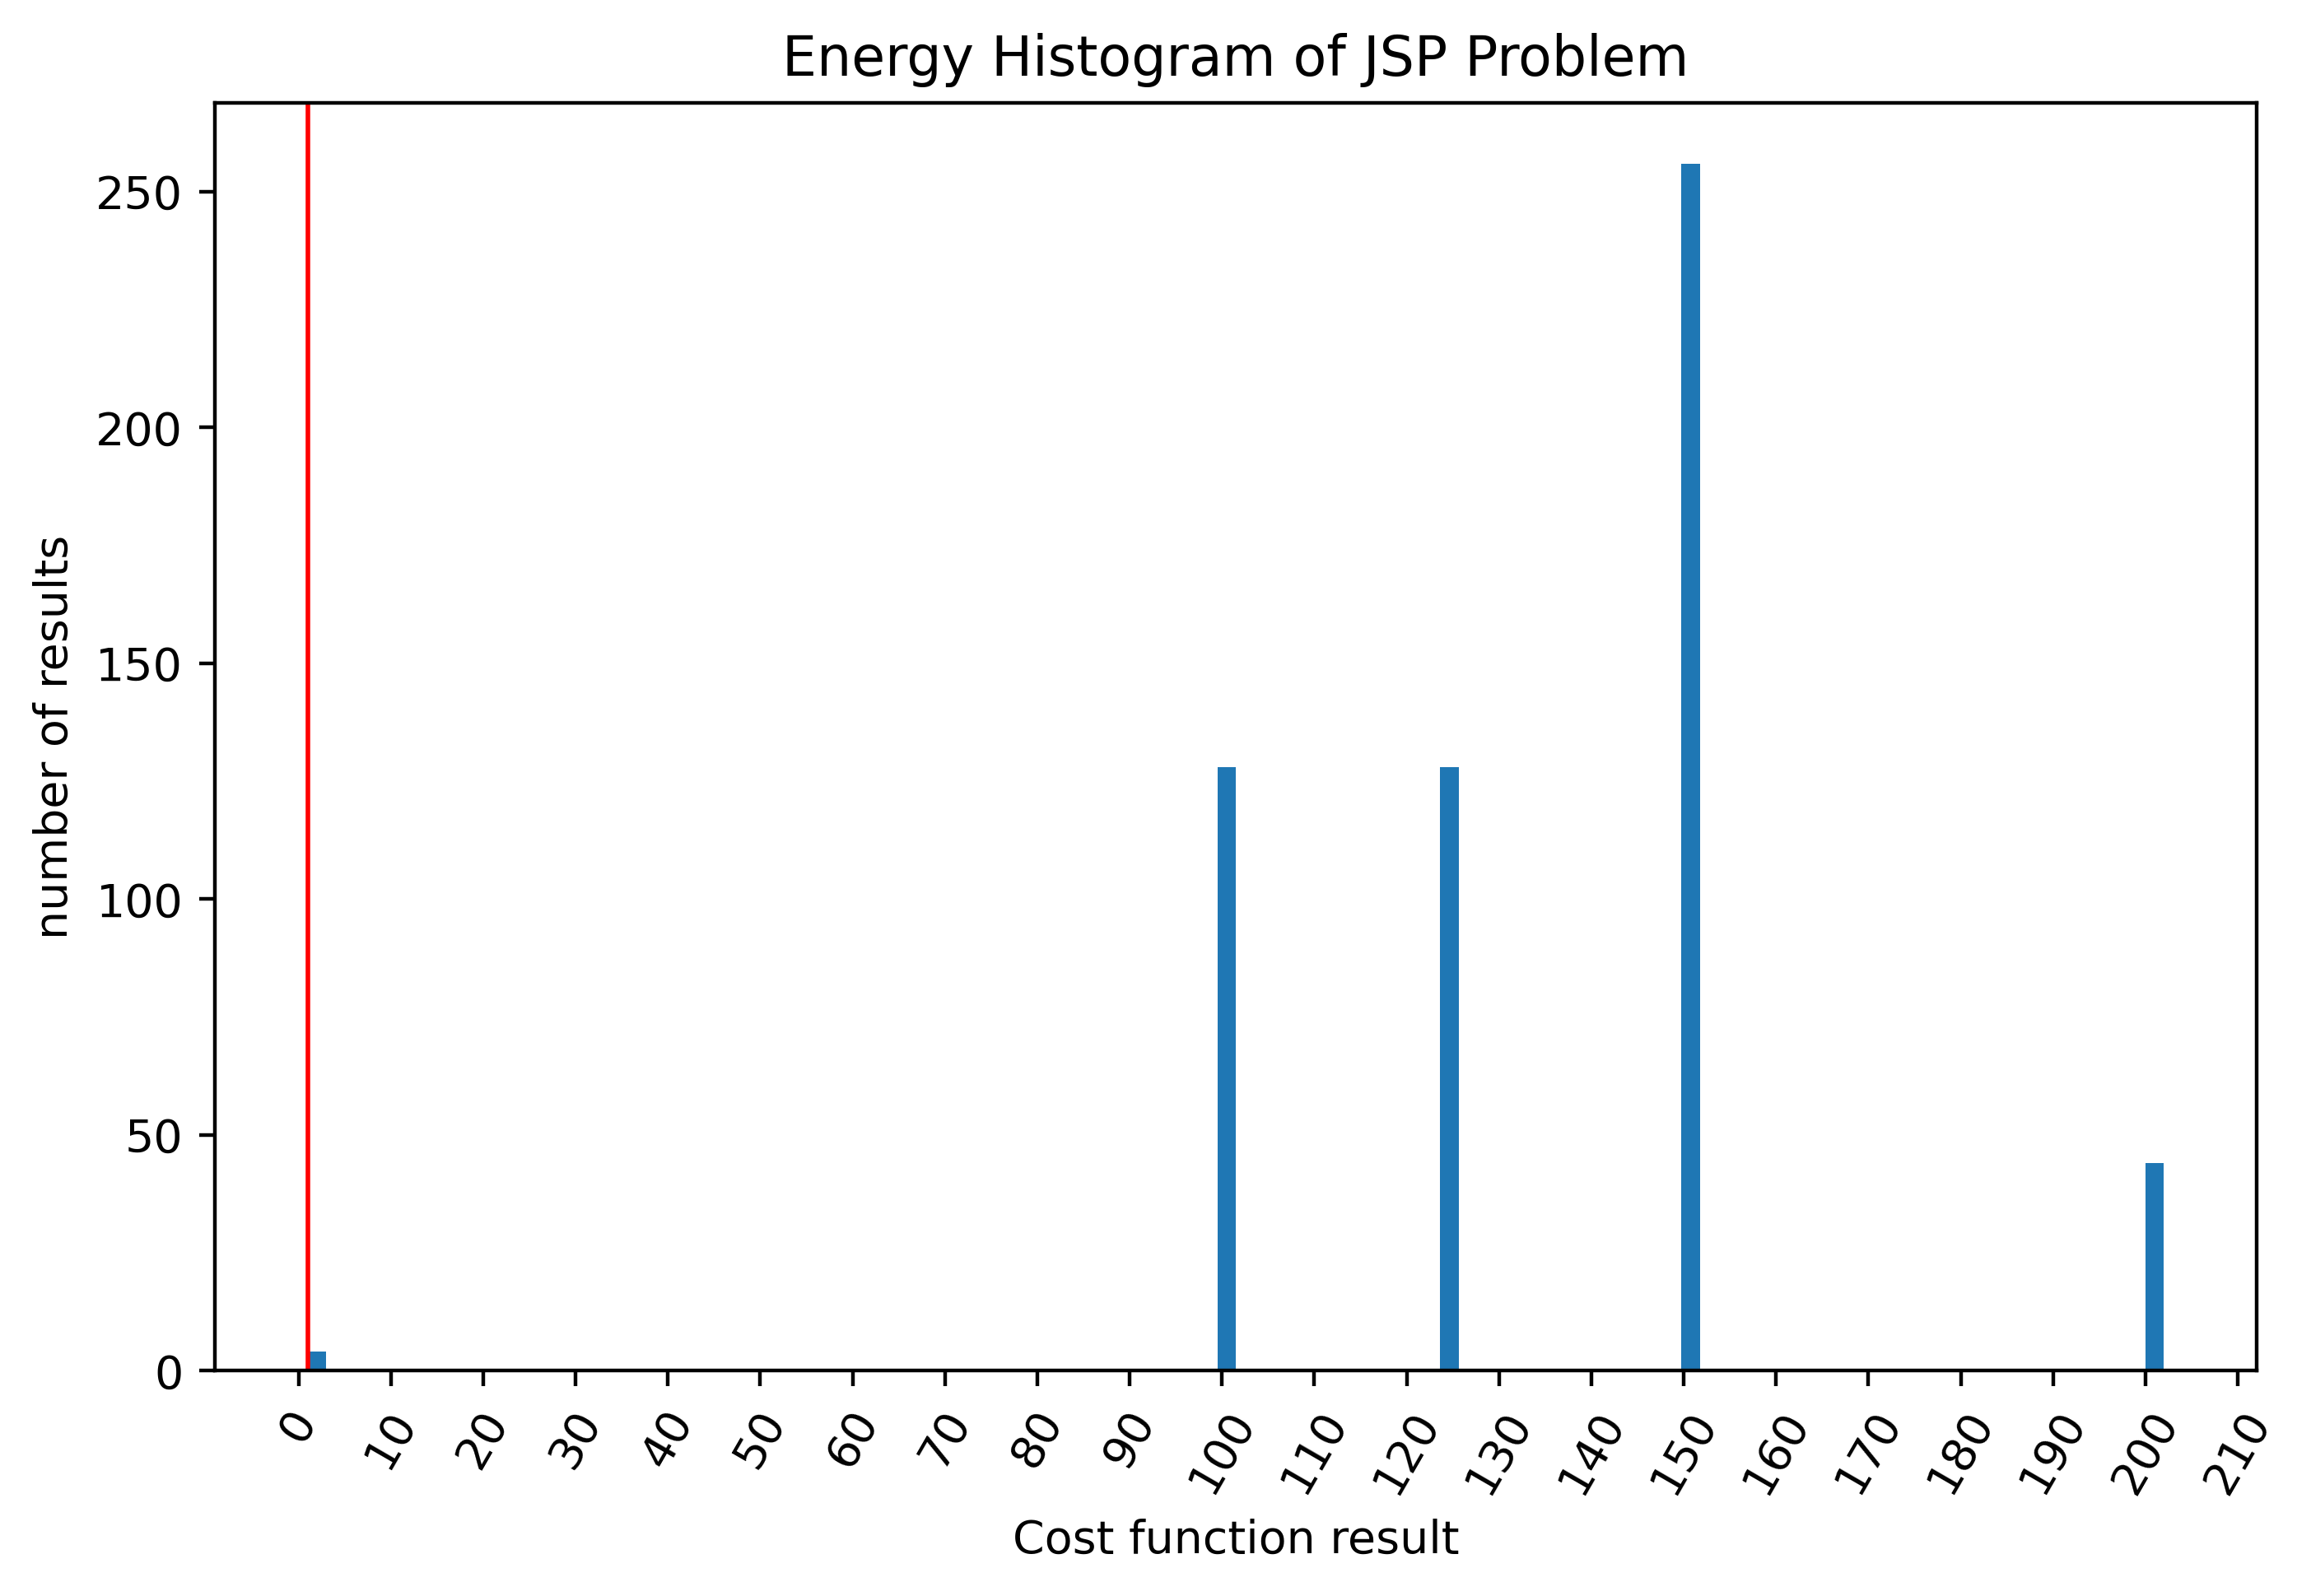

In [12]:
from experiment_utils import *

#####

landscape = run_and_record_landscape(H_total_JSP, 2, "JSP Problem")

**Ordinary VQE Experiment**

In [19]:
# '''
# Local minimum / Barren plateu parameters:
# [ 3.13187972  3.12485043 -1.44129882  4.00258695  1.8533889  -3.12973059
#  -1.08003222  1.32447117 -3.06463937 -1.37484716  3.00077516  2.21082978
#  -0.48120423 -0.65864836 -1.87660719  2.90869065 -0.01450286  0.0056704
#  -1.24626281 -1.18387608  0.84658704  0.143061    1.08438938  3.01307439
#  -2.92390669 -1.35869707  2.22695821 -1.74882826 -1.24884991  1.04685626
#   4.12047077 -0.1012765   3.14070326  0.01168365 -0.26387405 -2.08641117
#  -2.02884714 -0.67421794 -3.14378263 -0.04925929  1.80073301  3.12473985
#  -0.54310333  3.04640342 -1.34794034 -1.14862973 -0.00511756  0.30066454
#   0.011112    3.15367366  1.08694752 -1.66558516 -0.18201067 -0.91444362
#   1.57954499 -1.57272221 -0.98917923 -1.18253121 -3.31701255 -1.3658075
#   0.35165013  1.23242994 -0.80157646 -2.42548444]
# '''
# ### INITIAL THETA [1.0]*ansatz.num_parameters GETS STUCK, INITIAL THETA [0.0]*ansatz.num_parameters CONVERGES

ITERATION 0 - seed = 42
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 144.5735530978871
Optimal parameters: [ 2.69911583 -0.00534338  3.06005672  2.50416035 -3.13953939  3.6048187
  1.64263356  3.24796665 -2.74925637  0.8717672  -0.60815397  3.18313119
  1.02521978  2.47879563 -1.26254822 -2.36374882  0.43040444 -2.66737971
  1.68460176  2.32680348  2.44502086 -0.0495426   4.71428099  2.27376615
  1.6156577  -0.90047013  0.05679978 -3.24642136 -0.185743    1.31968455
  0.95221125  2.99170945 -0.41383418 -0.10434765 -1.47397342 -1.67932359
 -2.43153019  0.74369808 -1.13525895  1.50573467 -0.42258053  1.89901207
  3.59276255 -1.20761462  1.62368399  1.41739686 -1.62141913 -1.29514847
  2.69075084 -0.62525397 -1.07838101 -3.28336811  2.25222686  0.1103018
  1.37464613  1.47852257  0.82595281  1.20855212 -1.75606034 -1.57583476
  0.60203627 -0.35787764  1.05842386  1.03982922]


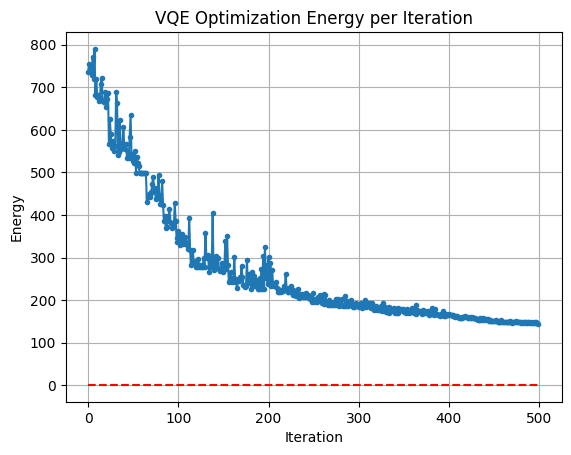

ITERATION 1 - seed = 43
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 156.20056126389377
Optimal parameters: [ 1.55512383 -1.58719624 -3.11762     3.20010584  1.49400769 -1.19279465
  1.55629014 -0.14750932  0.01828226 -0.00638421  3.11762648  3.48344075
 -1.02968642 -1.02711005  0.161106   -2.86200375 -1.56266029  3.19349842
  1.57329193 -0.07253855  1.502846    4.37299762  0.18579828  3.25376514
  3.4599136  -3.64817291 -1.64268122  2.69433868 -1.25504449 -1.21253363
 -1.57325676  1.7166813  -3.03777018  0.02800407 -0.03648713 -3.09605785
 -1.08973224  0.39796432 -1.37425148 -0.13778651 -0.28757502 -2.40983301
  0.87233845 -2.62450345  2.20827461 -2.5140396   0.81515535  2.11528559
 -1.48469809 -3.20400105  0.01842241  0.09987027  1.53521133 -2.84612388
 -2.36541705  2.87286231  0.65429698  0.64211544  1.76960312  1.84334341
  2.08596615 -1.23944963 -2.75353352 -3.12045094]


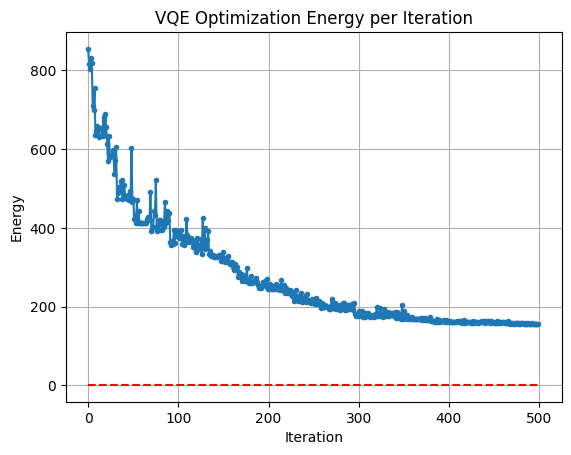

ITERATION 2 - seed = 44
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 112.91121247453381
Optimal parameters: [-3.21995856e+00 -2.30459394e+00 -8.85771048e-02  4.42749906e+00
 -1.60538854e+00  3.00773964e+00 -1.52661934e+00  5.18237552e-02
  2.03655579e+00  1.67237812e+00  3.09449622e+00  5.33684886e-02
  2.97671144e+00  3.44785267e+00  1.40520275e+00 -3.47345506e+00
  1.35914384e+00  3.15234455e+00  4.61251430e-02 -1.55367572e+00
 -1.97863888e+00  1.76321617e+00 -3.08106792e+00 -1.61167239e-02
 -3.17078437e-01 -2.17710611e+00  3.57647974e+00 -4.59623137e-01
  1.69659275e+00  2.07302250e+00 -1.64402995e+00 -2.87658715e+00
  2.82431085e+00 -2.83245015e-01  8.57008482e-03 -1.49796349e+00
  3.34668566e+00  2.94808275e-01 -6.35688938e-02 -1.47908782e+00
  2.90657671e+00  1.02430656e-01  1.58423220e+00  2.26786336e+00
 -1.13141630e+00  3.69398651e+00  3.09106757e+00  1.11139526e-03
  1.61474959e+00 -3.29173921e-01  1.48436698e+00  2.82277329e-02
 -2.5848745

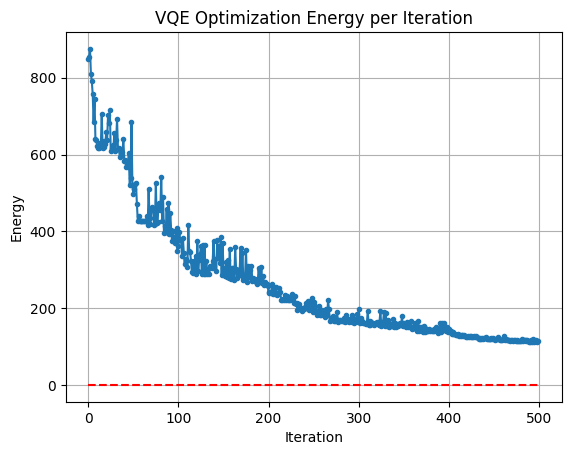

ITERATION 3 - seed = 45
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 119.57894745532923
Optimal parameters: [ 1.46127788  0.18414596  1.72277707  1.66433907  0.22304427  3.35810881
  1.99029047  0.28957541 -0.19835495  1.06370128  3.12658151  3.07015127
  2.76010527  1.49740007  3.12579068 -0.52771925  3.29827745  3.29840989
  1.33512624 -3.28178226 -1.7094229  -2.37564253  2.18944315 -2.54721319
  1.47137941  0.73827417 -0.59335819 -2.02814548 -2.21031072 -2.62394071
  1.54986196 -1.63956708  1.57374372  1.47806538 -0.04479885  2.98472968
  0.18553692 -2.86829777 -0.04011534 -0.44137657 -2.17054097  3.16102752
 -0.01912938  0.84147963 -2.40714212 -3.08362827  2.9358134   1.66574548
  0.87474903  1.58601498 -1.40561952  0.60457865 -0.25506828  1.95961672
 -1.44383552  0.52610969  1.70265655  1.30338452  0.24209683 -2.59462967
 -0.46609032  2.48186687 -2.4013141   2.03627429]


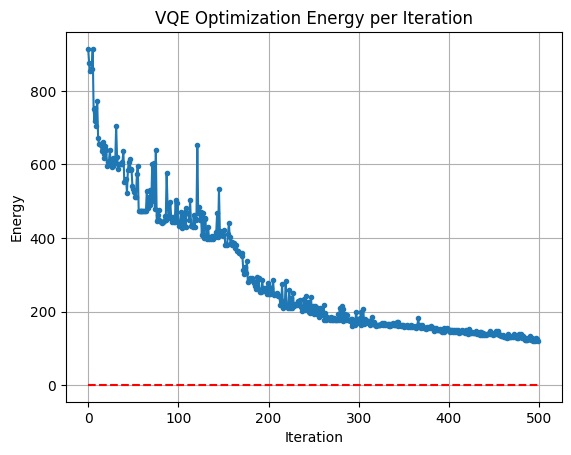

ITERATION 4 - seed = 46
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 103.65860554347468
Optimal parameters: [ 3.10518134 -3.12777621 -0.06582366  2.27576421  3.51068047 -1.50318905
  0.5376468   1.94916151 -1.00715304  3.30723492  3.05830448 -0.07797998
  4.19103128 -2.87521883  2.18109635  1.80204426 -3.19638871 -1.40003623
 -0.15727201 -0.73160097 -2.13441742  3.03050682 -1.7878073  -2.05279097
  0.85475935  0.78648311 -0.35557534  0.42473771 -3.16117629  1.15426386
  1.39663897  1.92474568  0.18356107  3.02653094 -0.13727922  1.12213131
 -2.48821019 -1.49125417 -2.9299833  -0.05585442  1.6626443  -2.57653096
  0.26536258 -1.53010199  1.32700432  3.2062555   0.74398745  0.55294852
  0.07484696 -1.49691802 -0.16699515 -1.84159535 -3.08747837  0.5054901
 -2.5947419   1.21332602  2.0973511  -0.2530286  -1.91200538 -0.76786571
  2.94276041  2.27389195  1.66735979 -2.15680908]


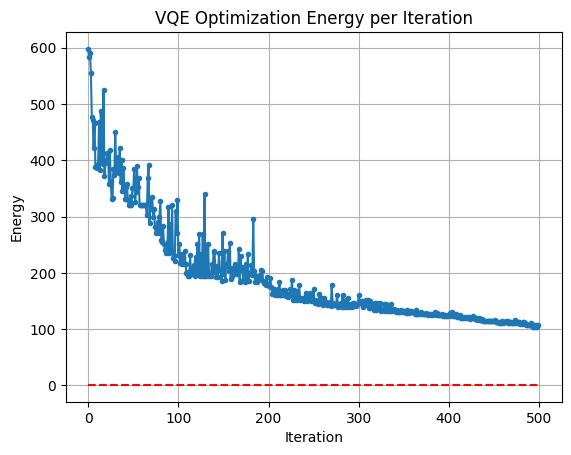

ITERATION 5 - seed = 47
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 145.10156246404225
Optimal parameters: [ 0.01264952  2.90074709 -1.03375632 -1.33351257  3.05435361 -0.06461236
 -0.68340202  4.38616719  1.15911737 -0.99471431  0.27983832  2.36355919
  1.1557041   1.66658041  1.00217462  0.15004387 -0.1012866   3.61866873
  1.98735948 -1.64269865  0.78245656 -3.1018393   1.04879725 -2.78556063
  3.33085769  1.63307465  1.93414838  2.64633485  2.44284173  0.30423799
  1.11004878 -1.54635627 -0.07450359  3.16582652  3.63394463  2.33378273
  0.56923903  0.15490786  1.67536169  3.16259746  1.99236374  3.30368403
 -2.61128833  0.45351888 -1.29742414 -1.63645958 -3.40252133  1.66390568
 -0.04037885 -2.77269339  4.71472288  1.48296603  1.02022787  0.90109451
  1.4993535  -0.20260681 -2.61974266 -0.49376585 -1.00632239  0.83234247
  1.01334284 -1.42404744 -1.46710121  4.00587795]


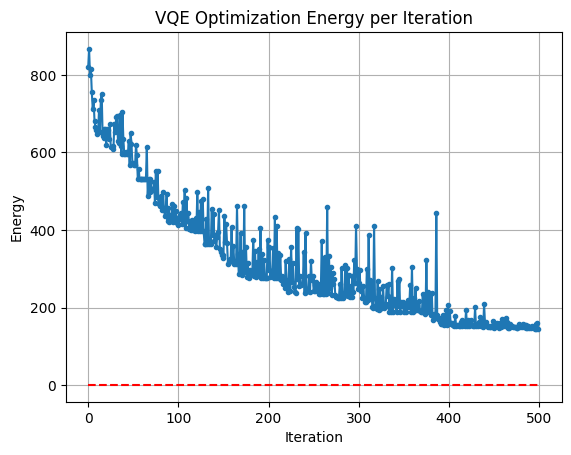

ITERATION 6 - seed = 48
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 110.41796130176509
Optimal parameters: [-4.99678183e-01  1.04474762e-02 -5.36947938e-04  1.10297367e+00
  7.56237104e-01  1.56425728e+00  1.60851392e+00  1.98824299e+00
  1.94502725e+00 -1.78761654e+00 -1.67197673e+00 -2.88974610e+00
  1.32373875e+00 -9.20169646e-02 -1.65174992e+00  1.45665393e-01
  1.44155916e+00  2.45855762e+00  1.70222778e+00 -2.37983176e-01
 -3.13394255e+00  1.60039449e+00  1.56710599e+00  2.07218425e-02
 -5.75306652e-01  1.77930176e+00  3.13979099e+00 -2.09506718e+00
 -1.65405512e+00 -1.33243737e+00  2.85324572e+00 -3.16189494e+00
  8.48645751e-01 -1.12961034e+00  1.61825532e+00  1.74084760e+00
  2.46388161e+00 -6.74018253e-01 -1.59958521e+00  1.80730419e-01
  3.79512761e-01 -6.54767617e-01 -2.93875320e+00  3.19611896e-01
 -2.81494469e+00  3.12438442e+00 -3.13996397e+00  4.58087487e-01
  1.50458524e+00 -2.68891703e+00 -1.39053998e+00  3.15384307e+00
  7.1697840

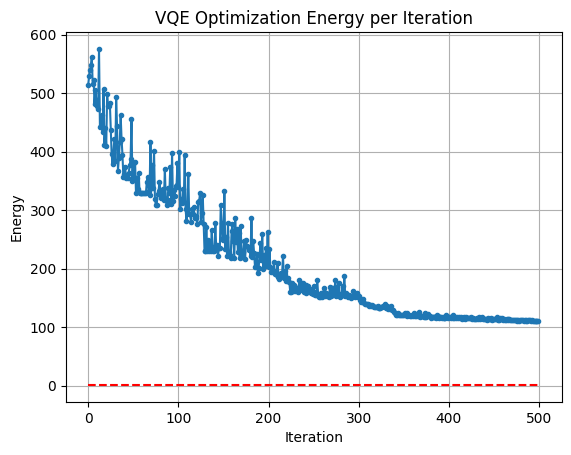

ITERATION 7 - seed = 49
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 112.22957758372483
Optimal parameters: [ 0.02542648  1.60934853 -0.0213169   0.43927037  0.16940307 -3.14212112
  2.18366886  3.70518524 -1.27145065 -3.14733983  3.37530956  0.78796928
  0.02064498  2.63231089  2.68948573 -0.1950124  -3.18738751 -2.79409098
  2.05129673 -2.95402498  1.68661947 -0.06805121 -1.46276216 -2.89151883
  1.52956572  0.34305149  2.41233076  1.96316389  2.05054058 -1.58859994
 -2.96876002  0.52144982 -3.15599967 -0.32992336  1.47253733 -0.12126226
  2.82186683  0.15071597  1.56499536 -0.63659366  1.2871353  -0.96234987
 -0.73017322  3.22900203 -2.0378174   0.10571977 -0.07316548  2.98634816
 -0.04145959 -1.73754162  2.13962934 -1.1365431   1.68740593  2.58805396
 -1.69738257  2.57229089 -2.67493537  2.29011418  2.0113963   0.68725247
 -0.25655263 -0.79080992 -2.36202867  0.71719799]


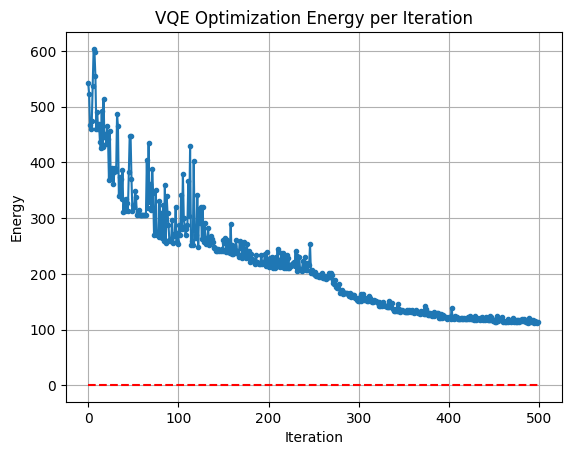

ITERATION 8 - seed = 50
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 72.68627009698692
Optimal parameters: [ 2.42340316  3.35443131  0.72912815  4.81770298 -1.60900167  2.11250958
 -1.11744973  1.47187045  0.41741544 -2.08335393  3.72227392 -0.19000822
 -1.55884487 -1.35310958 -1.84334862  3.08668675  0.74447689  1.96701843
 -2.15172878  0.82201369 -1.46623673 -1.53599409  0.89232224 -3.20180761
 -1.01215767 -2.71759778 -0.01783315 -0.84122048  0.87476155 -0.36325406
  0.98104937 -3.13065439  0.66309857  2.18923438  1.80847088 -2.94915018
 -1.90184424 -0.41873552 -0.84961174  0.00918623  3.27752733  3.12103956
 -4.24379033 -0.10638062  2.44191533 -1.52860671 -0.64336821  0.11026732
  1.72599409 -1.06436727  2.75797659 -2.21342722 -1.0368346  -1.35029927
 -0.37841912  1.19742738 -0.81238727  1.30504906  0.03290411 -1.99057622
  2.26937637  2.69172578 -2.65738806 -1.65505797]


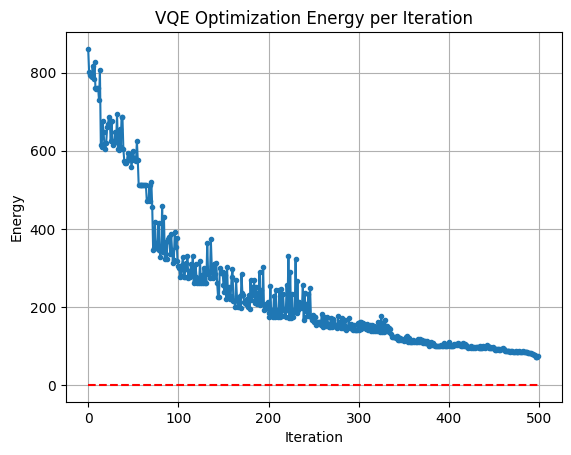

ITERATION 9 - seed = 51
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 111.67420739194769
Optimal parameters: [ 3.45493181e+00  1.80374426e-01 -1.66187917e+00 -1.38515786e+00
  3.10610110e+00 -1.61675246e+00  1.37362902e+00  1.95338326e+00
  2.39537236e-02  6.79686061e-01  3.12387334e+00  2.91963093e+00
 -1.42377250e+00  6.66493552e-01 -4.14193209e-01  4.95841451e+00
 -7.39759086e-02  7.02201895e-01  4.64380019e+00  1.07714037e-01
  1.57965305e+00  6.79237769e-03 -1.15744267e+00 -3.53302021e+00
 -1.47916137e+00 -5.87038727e-01 -3.69097025e-01 -8.54228560e-01
 -3.88671639e-01 -9.78151708e-01  1.29643798e+00 -1.34897659e+00
  1.63836774e-01  1.38423652e+00  1.62042248e+00 -3.35168997e+00
  3.16385675e+00  4.90522103e-03 -2.21022472e+00 -3.13569691e+00
  1.17402406e+00  2.50586465e+00  3.07792587e+00 -2.09443879e+00
  2.44185279e+00  2.12583010e-03  1.49538131e+00 -1.36359809e+00
 -2.75049146e+00 -1.14306860e+00 -2.22952537e+00 -1.03331725e+00
 -3.4439506

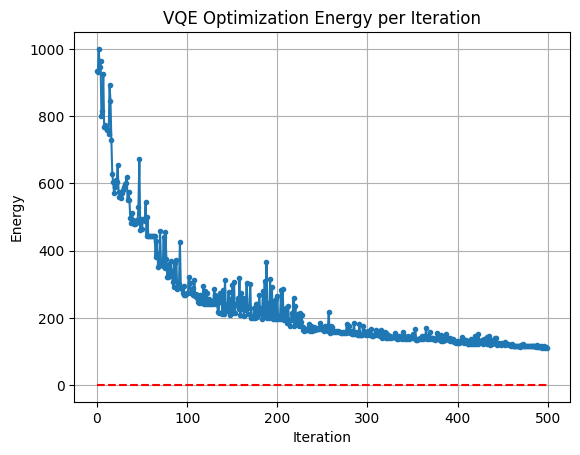

ITERATION 10 - seed = 52
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
from experiment_utils import *

# energy_values = []
# theta_path = []
# vqe_result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, maxiter=1000, seed=42)
# vqe_final_thetas = vqe_result.optimal_point
run_VQE_stats(H_total_JSP, min_eigenvalue.real, 30, maxiter=1000)

**Perturbed from Local Minimum**

In [1]:
# epsilons = np.linspace(0, 0.2, 3)
# average_distance_from_local_minimum = []
# std_distance_from_local_minimum = []
# average_final_score_function = []
# std_final_score_function = []
# #std as well

# for epsilon in epsilons:
#     distances = []
#     eigenvalues = []

#     for s in range(5): #average
#         #Just for sampling
#         np.random.seed(s)
#         perturbed_thetas = vqe_final_thetas + epsilon * np.random.uniform(-1, 1, len(vqe_final_thetas))

#         energy_values = []
#         theta_path = []
#         result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, initial_thetas=perturbed_thetas, maxiter=2000, seed=s, verbose=False)
        
#         distances += [np.linalg.norm(result.optimal_point-vqe_final_thetas)]
#         eigenvalues += [result.eigenvalue.real]
    
#     average_distance_from_local_minimum += [np.average(distances)]
#     std_distance_from_local_minimum += [np.std(distances)]
#     average_final_score_function += [np.average(eigenvalues)]
#     std_final_score_function += [np.std(eigenvalues)]

In [2]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# # Create the first plot: Average Distance from Local Minimum vs Epsilon
# plt.subplot(1, 2, 1)
# plt.plot(epsilons, average_distance_from_local_minimum, marker='o', linestyle='-', color='b', label='Average Distance')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  [avg + std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  color='b', alpha=0.2, label='Std Deviation')
# plt.title('Average Distance of the Final Point from Local Minimum vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Average Distance')
# plt.grid()
# plt.legend()

# # Create the second plot: Final Score vs Epsilon
# plt.subplot(1, 2, 2)
# plt.plot(epsilons, average_final_score_function, marker='o', linestyle='-', color='r', label='Average Final Score')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  [avg + std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  color='r', alpha=0.2, label='Std Deviation')
# plt.title('Final Eigenvalue vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Final Eigenvalue')
# plt.grid()
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()


In [3]:
# for i in range(4):
#     visualize_path_2d(theta_path, i, i+1)
# for i in range(4):
#     visualize_path_1d(theta_path, i)

**Running on MUB initial states**

NUMBER OF QUBITS 8 8
Ground state energy: 100.9109138461168
Optimal parameters: [-9.98330558e-03 -1.46866950e-02 -8.79191404e-01  1.09445733e+00
 -1.44281991e-02  7.92305076e-03  1.05522286e+00  4.66622153e-01
 -2.53783097e-03  4.87061955e-03  3.46865908e-02  1.32067041e-03
 -1.03401699e-01  1.10027152e+00  1.64966813e+00  8.83473941e-01
  7.71068175e-01  2.54507371e+00  1.56633566e+00  1.02312581e+00
  1.40481411e+00  1.21536662e-03  6.99588169e-01  1.45171165e-01
 -2.99719997e-03  1.51324640e+00  2.16575954e-01  1.72570922e+00
  1.08215945e-01  8.96090743e-01  1.58259583e+00  9.74947572e-01
  4.07251006e-02  7.17420594e-02  4.30363764e-01  3.32597136e-01
  8.08140416e-01  1.00182316e+00  1.36744266e+00  1.54027518e+00
  2.46049088e+00  7.06516442e-01  7.18862789e-03  9.81393386e-01
  1.31268245e+00 -1.20629956e-02  1.81337490e+00  2.92675918e-01
  6.11627730e-02  1.46486222e+00  2.68920502e-01  5.47833315e-01
  8.87796245e-01  9.38662382e-01  2.26445757e-01  8.50391198e-01]


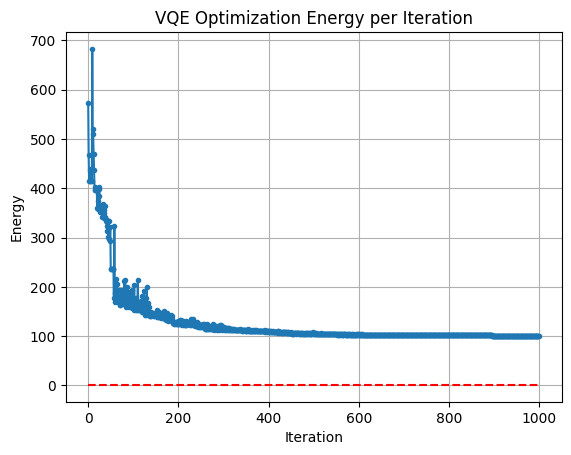

In [12]:
from experiment_utils import *
from vqe import *

energy_values = []
theta_path = []

run_VQE_MUB(H_total_JSP, min_eigenvalue.real, energy_values, theta_path, state_idx=3, mub_idx=2)
#TODO TODAY - make a function that goes through all triples and calls this function (for this, edit the permutation mask)

**All MUB states for first 2 qubits**

ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.49484141168669
Optimal parameters: [-1.68020278e-03 -3.53841325e-03  4.64792401e-01  9.71323830e-01
 -6.20139670e-03  1.85854536e-03 -6.73084537e-01  2.97911435e-01
  2.60682696e-02  1.41643279e+00  1.56942065e+00  1.63443372e+00
  1.82063016e+00 -2.27065639e-01  1.98320482e+00  1.04578033e+00
 -1.26244537e-02 -1.13802491e-04  7.29887993e-02  2.30903604e+00
  1.19626183e+00  4.45344229e-01  1.58922200e+00  1.57408749e+00
  1.57105283e+00  1.61635322e+00 -6.19985560e-02  1.02525137e+00
  1.45077194e+00  8.22346333e-01 -2.12704839e-02  3.35663233e-02
  1.19400990e+00  1.46752572e+00  1.00320130e+00 -7.93877672e-04
  5.76193058e-02  1.48959532e-01  2.23669177e+00  2.22258208e+00
  1.71884397e+00  1.17329256e+00  1.77839040e+00 -3.72021764e-01
  4.58415824e-01  1.59173717e-01  2.04571112e+00  1.04975219e+00
  3.06173093e-02  1.56487904e-01  8.35471596e-01  1.44373825e+00
  1.60156238e+00  7

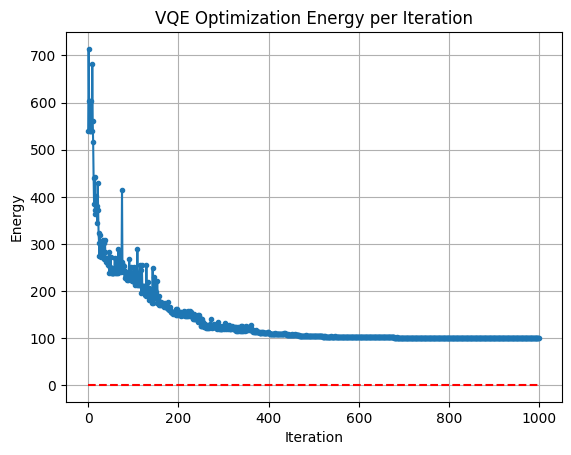

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

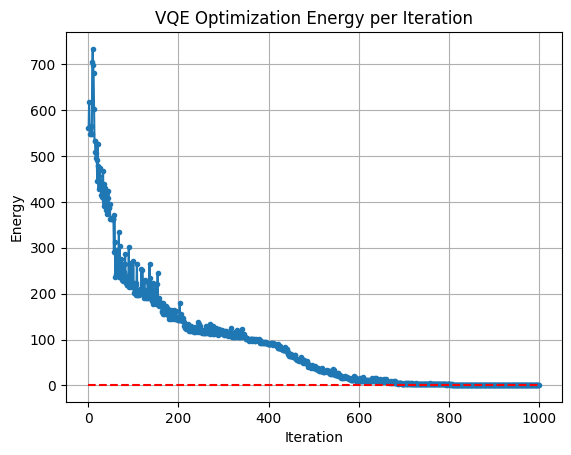

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=0, state_idx=2)
NUMBER OF QUBITS 8 8
Ground state energy: 100.52228670405425
Optimal parameters: [ 2.65038733e-02  1.34626923e+00 -4.79156352e-01  1.37496766e-03
 -2.72978946e-02  4.93515988e+00  1.55130069e+00 -1.77527210e-01
  8.28619044e-04 -2.85151785e-02 -1.93299317e-03  9.26870992e-04
 -9.81955678e-02  4.78612929e-01  8.37628537e-01  8.62883250e-01
  1.17464840e+00  1.86429015e+00  1.10965607e+00  2.22365850e+00
 -4.15261610e-02  1.69942536e-02  1.79701702e+00  2.11091881e-03
  1.51705614e+00  1.65022892e-01  5.28983350e-01  1.38489153e+00
  8.81236198e-01 -3.07415483e-01  1.83467287e+00  5.88642841e-01
 -5.60576399e-04  1.52157737e+00  6.88842350e-02  3.94880194e-02
  2.48276927e-01 -4.09220442e-02  1.29689520e+00  1.64126201e+00
  5.62322540e-01  1.76505099e+00  9.83483586e-01  3.14618981e-01
 -4.26690070e-02 -3.00660730e-01  1.32879375e+00  1.60848360e-02
  1.57311942e+00  3.29310530e-01 -5.76994118e-01  8.89687188e-0

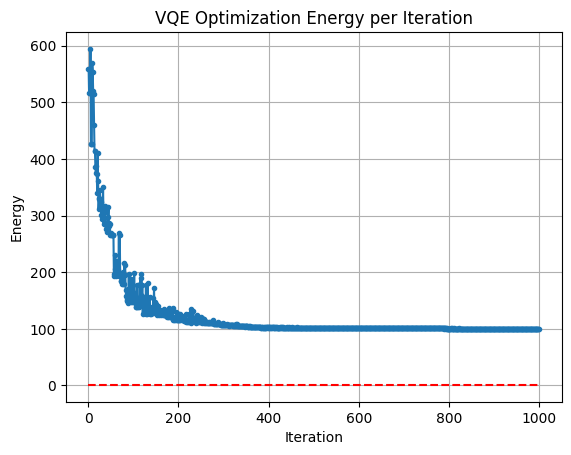

ITERATION 3 === MUB VQE STATE (mub_idx=0, state_idx=3)
NUMBER OF QUBITS 8 8
Ground state energy: 104.43054281419894
Optimal parameters: [ 1.20992027e+00  1.57387866e+00  6.22228838e-03  1.82776510e-02
  5.05951012e+00  4.71461557e+00  1.08124665e+00 -6.48599676e-01
 -3.99760732e-01  6.55788055e-01 -3.55898699e-03  3.76373040e-03
 -8.61749060e-01  1.66129513e+00  8.47918851e-01  1.30448140e+00
  7.21433267e-01  1.16687193e+00  9.89797403e-01  2.79387418e+00
  5.50116106e-01 -1.67762039e-01  1.11303702e+00  6.14343550e-03
  4.84892779e-01  4.49127205e-02 -3.44025762e-01  8.13331330e-01
  1.14798019e+00  5.02920736e-01  1.29693382e+00  8.74783624e-02
  2.20579222e-02  2.85939921e+00  1.13179817e-01  2.10848205e-01
  7.88967868e-01  1.63191637e-01  1.61986607e+00  1.08003282e+00
  7.04357824e-01  1.24858540e+00  9.37825908e-01  2.39224655e-01
  4.80046310e-01  3.80938094e-01  4.57653112e-01  1.24059222e-01
  1.59217265e+00  1.50727938e+00  1.71597090e+00  7.75656805e-01
  3.82027401e-01  7

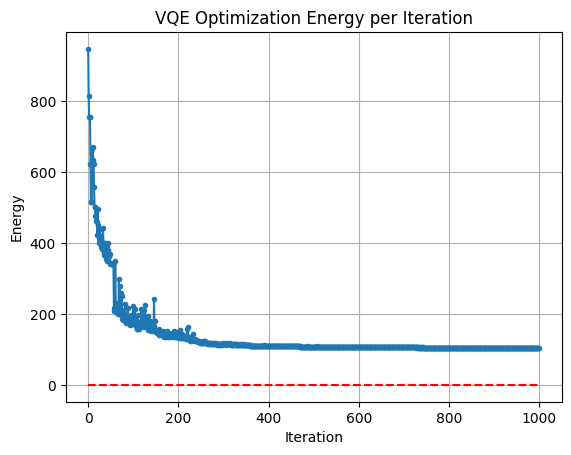

ITERATION 4 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-01
 -3.93029905e-01  6

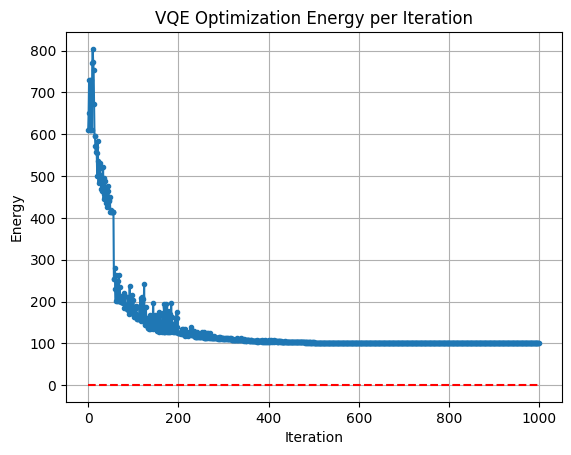

ITERATION 5 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

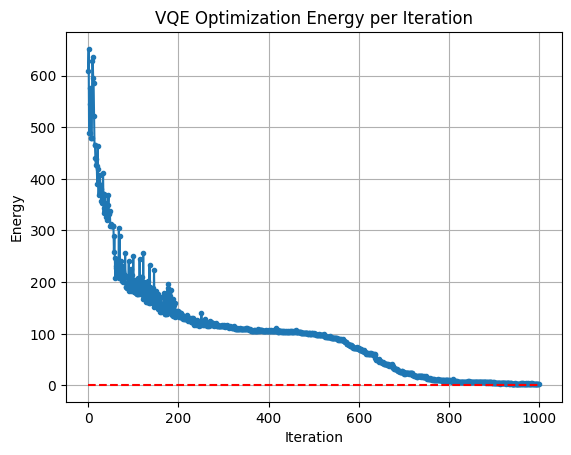

FOUND GLOBAL MINIMUM
ITERATION 6 === MUB VQE STATE (mub_idx=1, state_idx=2)
NUMBER OF QUBITS 8 8
Ground state energy: 101.0032248666758
Optimal parameters: [ 3.14330409e+00 -4.68923073e-01  8.48596982e-01 -7.91531596e-03
  3.13874626e+00  2.66956204e+00  8.91540360e-01  1.40275676e-02
 -1.70991233e-03  9.71474136e-02  2.04948695e-02 -9.14018332e-03
 -6.58187179e-02  1.62199310e+00 -3.72088782e-02  5.73708637e-01
  9.13612885e-01  1.00290603e+00  1.38633344e+00  2.59522459e+00
  1.67525155e-02 -3.92406608e-02  1.56777231e+00 -3.38874431e-02
  7.99643351e-01  5.84353857e-01 -1.99790720e-01  1.35866844e+00
  1.58335814e+00  8.32184343e-01  2.17255785e+00  1.40632012e-01
  3.69135336e-03  1.44934270e+00  2.66069802e-01  2.45531092e-01
  9.09742530e-01 -2.59587736e-01  2.38255878e+00  5.12154436e-01
  6.72544067e-01  8.93507985e-01  5.97700993e-01  3.24426657e-01
  9.67896301e-03  1.69167408e+00  1.42897786e+00 -3.29095572e-03
  1.57587867e+00  1.10317288e+00  9.51898422e-01  1.58681589e+00

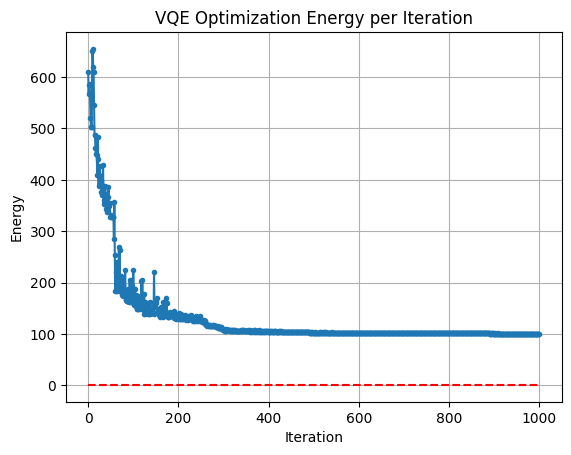

ITERATION 7 === MUB VQE STATE (mub_idx=1, state_idx=3)
NUMBER OF QUBITS 8 8
Ground state energy: 100.61873680662877
Optimal parameters: [ 3.14322277e+00 -2.15924716e+00  1.05349817e+00 -6.20110697e-03
  3.14219485e+00  9.84514692e-01  2.01481359e-01  1.21136918e+00
  1.96738068e-03  1.37104068e-02  2.30911833e-03  4.98018846e-03
 -2.04955876e-01  1.52478183e+00  1.24324171e+00  1.04920208e+00
  1.58914597e+00  8.94581168e-01  2.12862991e-01  2.16383419e+00
  1.17103575e-03 -4.36133664e-03  1.49071001e+00  2.63871241e-03
  1.14739925e+00  2.16926302e-01  6.08817663e-01  1.61130478e+00
  1.83948478e+00  4.86668998e-01  1.50970005e+00 -1.42132830e-01
 -1.32003679e-03  1.80376398e+00 -6.32833836e-03  6.74899496e-04
  1.37552465e+00  3.74486892e-02  1.66059048e+00  1.62417768e+00
  7.13714656e-01  6.10057656e-01  9.71261347e-01  6.94568174e-01
  2.62712981e-03  1.95918774e-01  1.65441905e+00  3.82033318e-03
  1.56905695e+00  5.69218155e-01  8.87099789e-02  2.58008084e+00
  8.57967214e-01  1

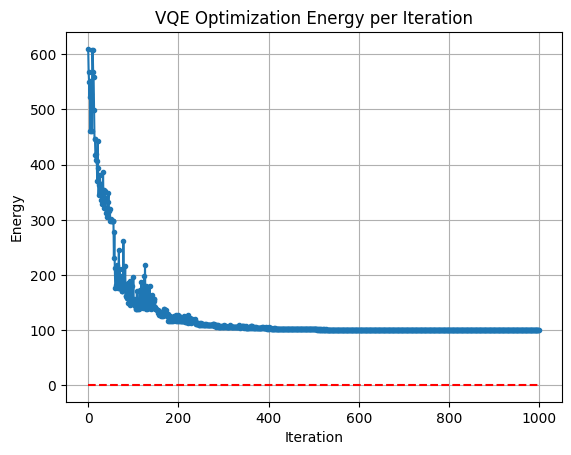

ITERATION 8 === MUB VQE STATE (mub_idx=2, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 2.073920869449053
Optimal parameters: [ 1.51016169 -1.32835266 -1.7349599   1.55351971 -1.83120036 -0.15907622
 -0.17760525 -1.11914858 -0.01731248 -0.01450183  0.02231045  0.0065709
  0.02870605  0.71273198  0.23444371  1.18678303  0.50767439  1.93762106
  1.58391982  2.13186581  0.00828659 -0.01445884 -0.04082793  0.00561329
  1.00026385 -0.03197817 -0.44809564  1.46569051  0.73271961  0.11568276
  1.75868978  0.13561089  0.26522552  3.18307597  0.029808   -0.01359642
  0.51857681 -0.11352165  2.45075191  1.52034864  1.46780685  0.73143449
  0.90924823  0.42683693  0.00411259  0.06103898  3.07678303 -0.03230144
  1.09352972  0.58644638  1.43579533  1.92357472 -0.16062713  0.23344059
  0.07197872 -0.3557969 ]


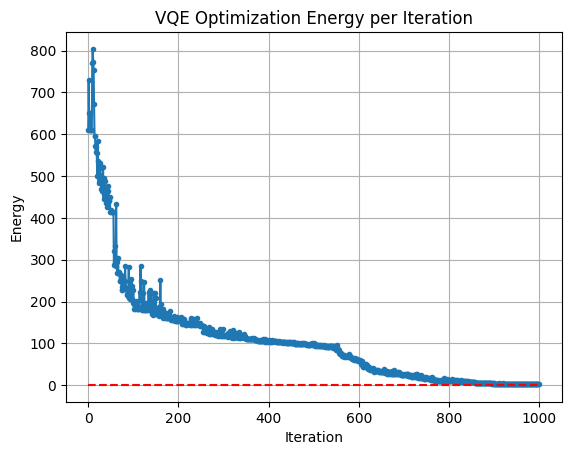

FOUND GLOBAL MINIMUM
ITERATION 9 === MUB VQE STATE (mub_idx=2, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 3.9766455708874022
Optimal parameters: [-0.57649338  2.81386305 -1.64837021  0.93747198 -0.24347783  0.28023788
  0.04198396  1.74568769  0.01426924  0.03207384 -0.00626627  0.00784617
  0.25682057  1.34942974  1.40428867  0.46058363  1.41961238  0.69237967
  2.08978113  1.97655993 -0.07721856  0.01950842  1.41993792 -0.0128967
  1.50916075  1.13622689  0.54546217  1.73999186  3.15710064  0.82076884
  1.52936271  0.04244492 -0.08963318  2.78768776  0.14478066 -0.13622649
  1.12545664 -0.00649755  1.59140633  2.76464323  1.22609242  1.91260321
  0.99223455  0.85908317  0.10923219  0.33937014  1.69808878  0.01180065
  1.59140155  0.02443135 -0.73910716  0.38999681  1.18761774  1.03876067
  0.16184537  1.43043806]


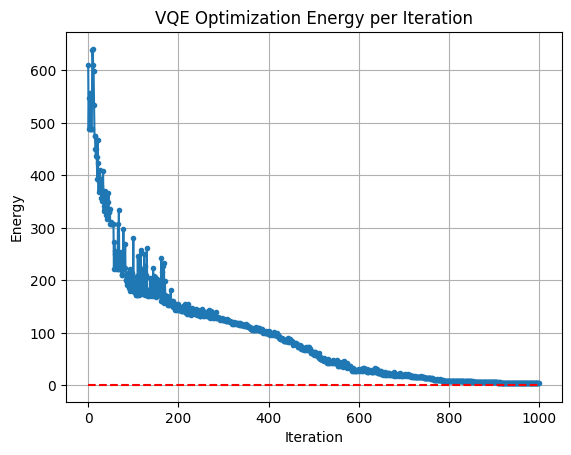

FOUND GLOBAL MINIMUM
ITERATION 10 === MUB VQE STATE (mub_idx=2, state_idx=2)
NUMBER OF QUBITS 8 8
Ground state energy: 1.3251155924866735
Optimal parameters: [ 1.63028026e+00  1.88974945e+00 -1.73267411e+00  1.61894166e+00
  1.25600831e+00  1.34294809e-01 -1.31103311e-01 -1.11675125e-01
 -8.03929895e-03 -9.35611284e-04  1.04648838e-03  6.82539104e-03
 -1.72362699e-01  6.54973693e-01 -8.37733216e-01  7.92201428e-01
  1.69412691e+00  1.82985119e+00  3.47054705e-01  1.45255469e+00
  4.46415155e-03  4.89732383e-03 -2.26808157e-03  2.63079657e-03
  1.39598578e-01  6.26930550e-02  8.06178434e-02  1.51788401e+00
  1.37370166e+00  4.93821237e-01  1.38991813e+00  8.83284521e-01
  8.99725860e-01  3.13363914e+00 -9.36500070e-03 -8.38741065e-03
 -1.21542349e-01 -2.05361722e-01  1.74702168e+00  1.46176873e+00
  1.20128491e+00  1.87375390e+00  1.66871540e+00  7.58460984e-01
 -5.98198044e-04  1.19492236e-02  3.13033015e+00  1.28171988e-02
  1.94770265e-01  8.09713360e-01  6.64808527e-01  2.93596676e+

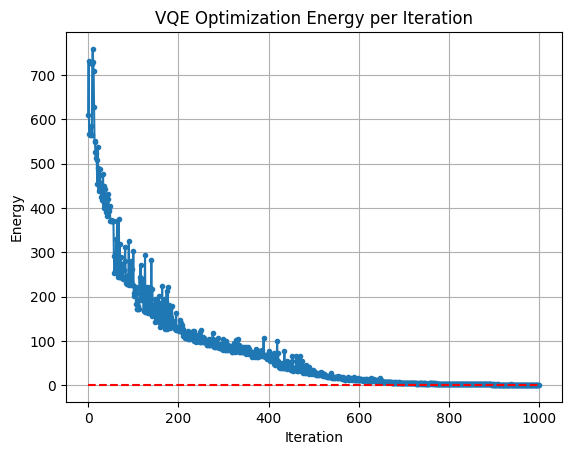

FOUND GLOBAL MINIMUM
ITERATION 11 === MUB VQE STATE (mub_idx=2, state_idx=3)
NUMBER OF QUBITS 8 8
Ground state energy: 100.7080286457913
Optimal parameters: [-2.96496237e-03 -2.67268896e-02 -4.26833571e-01  2.34247344e+00
 -2.89046248e-02 -5.88517748e-03  4.18825659e-01  2.41555547e-01
 -3.09423540e-03 -2.11417307e-03  1.65727295e-03  8.26349522e-04
 -2.03427782e-01  4.87843608e-01  7.89201308e-01  2.69741320e-01
  2.14400919e+00  1.45688634e+00  2.19870905e+00  2.40353461e+00
 -7.07436230e-03  1.82845410e-02  6.59087348e-01  3.24657433e-03
  1.51868484e+00  2.75830209e-01  2.41715587e-01  1.67285353e+00
  8.56341743e-01 -4.39341679e-01  1.72844819e+00  2.23112448e-01
 -1.00298524e-02  1.95626328e+00  9.58664835e-03  2.50680082e-02
  2.89581764e-01  8.82060758e-02  1.68659859e+00  1.10088294e+00
  1.40635956e+00  6.15739433e-01  6.49466898e-01  6.82950236e-01
  2.79908690e-03 -1.52057153e-01  2.42831358e+00  1.83782782e-02
  1.53230358e+00  2.15913763e-01  5.32795975e-02  6.90544992e-0

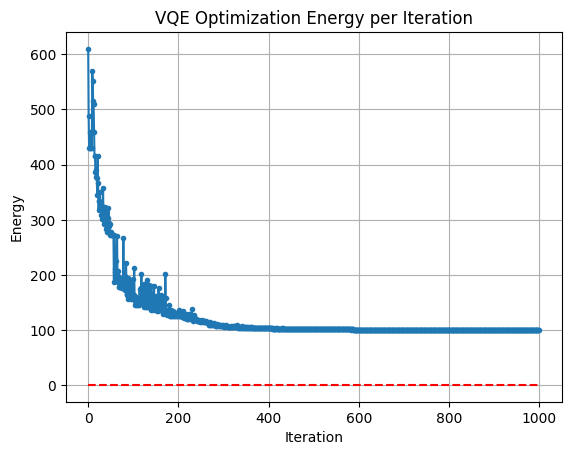

ITERATION 12 === MUB VQE STATE (mub_idx=3, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 1.029857825286541
Optimal parameters: [ 1.57851920e+00  9.37275628e-02  3.12621927e+00  2.92005011e+00
  1.32374167e+00  1.81778870e+00 -1.19594855e+00 -1.83080702e+00
 -7.31134379e-04  3.10769830e-04  1.90315870e-03 -8.95535825e-04
  4.70865798e-01  6.11747500e-01 -5.77628804e-01  5.67373379e-01
  1.85943951e+00  1.48941032e+00  1.56546129e+00  1.99441314e+00
 -1.40967822e-03 -3.14994305e-03 -2.13292754e-03 -2.93427685e-03
  3.17518846e-01  7.27569568e-01 -1.10941154e-01  6.90480246e-01
  1.97574332e+00  1.19601549e+00  1.70412378e+00  2.93396897e-01
 -8.96660248e-02  3.13644505e+00 -2.67879609e-03  1.45559998e-03
  4.69055743e-01 -5.00475916e-01  1.91550534e+00  1.90298374e+00
  1.03471928e+00  1.96989474e+00  1.08918496e+00  1.13238867e+00
  2.82718747e-03  1.47702927e-02  3.14508279e+00 -3.79017017e-03
  4.80522226e-01  5.68422016e-01  1.39821651e-01 -1.01360625e-01
  7.14617615e-01  1

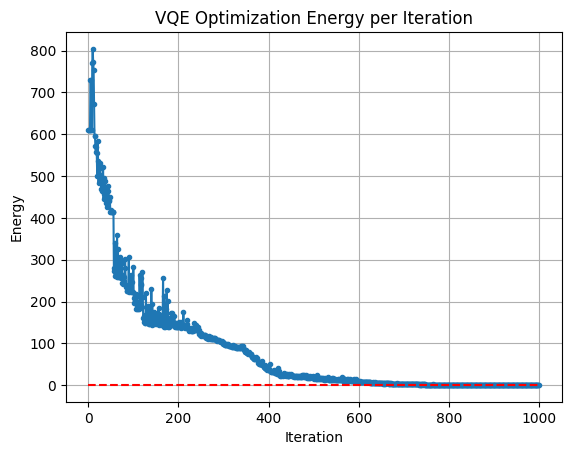

FOUND GLOBAL MINIMUM
ITERATION 13 === MUB VQE STATE (mub_idx=3, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.4898944269164547
Optimal parameters: [ 1.32855865e+00 -4.29902299e-01  7.89306955e-01  1.83982741e+00
  2.60284007e+00 -4.08649405e-01 -4.93196161e-01 -1.71858028e+00
 -8.83235901e-03  7.07887247e-03  4.67147465e-03  2.08246674e-02
 -1.64074848e-02  1.44981323e+00 -7.58213054e-01  3.78481654e-01
  1.04282465e+00  1.28357039e+00  9.91268086e-01  2.64519531e+00
  4.57585282e-02 -2.75781198e-02 -1.47261724e+00  9.92537736e-03
  2.87010765e-01  1.07794077e-01  4.83859771e-02  1.20943839e+00
  1.50505435e+00  9.70760699e-01  2.11893010e+00  2.55019055e-01
 -1.21579250e-02  6.28922030e-01 -2.64452119e-02  1.73130666e-04
  1.40080355e+00 -2.11046740e-01  1.58763402e+00  2.83301353e+00
  6.03303706e-01  1.03368668e+00  2.37773628e-01  2.32993675e-01
 -5.94342453e-02  2.52456599e+00  1.47275498e+00 -1.07157415e-03
  1.57709383e+00  1.48607776e+00 -1.85950888e-01  4.39346759e-

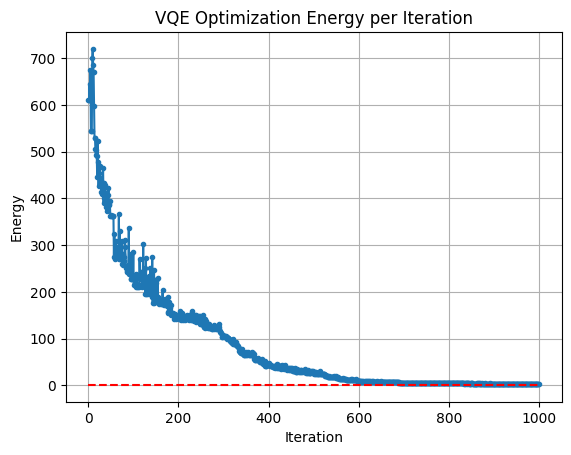

FOUND GLOBAL MINIMUM
ITERATION 14 === MUB VQE STATE (mub_idx=3, state_idx=2)
NUMBER OF QUBITS 8 8
Ground state energy: 1.8007777738592716
Optimal parameters: [-1.39957072e+00 -3.13313128e-02 -1.34449106e-02 -1.59449441e+00
  9.73801489e-01  2.15035324e+00  2.31691174e+00  6.33493557e-01
  8.56460051e-03  3.54006206e-03  6.42591942e-03  1.66604603e-02
 -8.73653383e-03  4.42560729e-01  1.81392881e-01  1.39461129e+00
  9.80949279e-01  1.76101313e+00  5.83824363e-01  1.90821338e+00
 -3.27282271e-03  2.64722370e-03  2.26067006e-03  1.95970497e-02
  3.58989950e-01 -9.03271608e-01  7.87783075e-01  6.19220075e-01
  2.28979109e+00  7.91186740e-01  1.19493364e+00 -2.49994605e-01
 -2.15612343e-02  3.14063741e+00  1.96404032e-02  5.43297491e-03
  3.64572523e-01  1.93249028e-01  1.69600114e+00  2.05868775e+00
  1.91311593e+00  1.91972405e+00  7.89952880e-01  7.52467438e-01
 -2.15610693e-02  5.08928398e-02  3.14224959e+00 -2.09697855e-02
  4.37894435e-01  9.21584929e-01 -4.04358385e-01  9.04765630e-

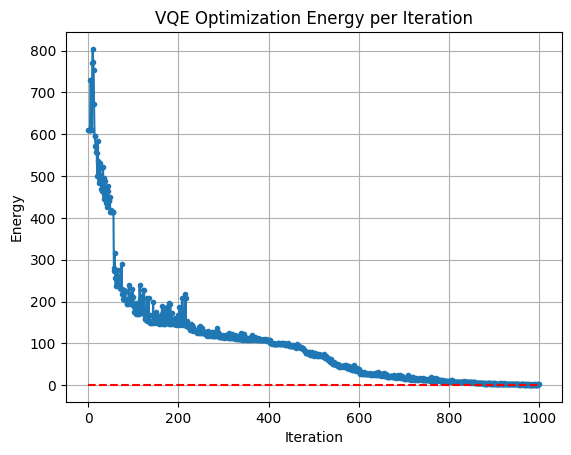

FOUND GLOBAL MINIMUM
ITERATION 15 === MUB VQE STATE (mub_idx=3, state_idx=3)
NUMBER OF QUBITS 8 8
Ground state energy: 101.00286562974158
Optimal parameters: [ 9.92449978e-04 -2.88762109e-03 -1.39376914e+00 -1.48245448e+00
  3.41198432e-03 -9.96093509e-04  2.78017293e+00  2.13793074e+00
  3.23026748e-04  1.51487862e-02 -7.31320632e-04 -2.54902284e-03
 -5.96122610e-02  1.13828311e+00 -4.23089999e-01  2.78662672e-01
  8.65477330e-01  2.33004440e+00  8.78567528e-01  2.56332760e+00
 -7.35784103e-04  5.39836065e-02  1.56689146e+00 -1.58489569e-03
  1.50473018e+00  1.34784676e+00  2.87539677e-01  1.67103142e+00
  9.16099144e-01  6.83925207e-01  7.10047206e-01  4.95397424e-01
 -4.78107948e-04  1.92150067e+00  2.44202466e-01  2.39481458e-01
  7.63545364e-01  5.55209543e-01  1.74322970e+00  4.29642271e-01
  1.08804668e+00  1.14159691e+00  9.39411919e-01  1.29419972e+00
  1.97839590e-03  1.39282453e+00  1.47674020e+00  6.81499963e-03
  1.57201022e+00  4.58152887e-02  1.51005390e+00  1.31040807e+

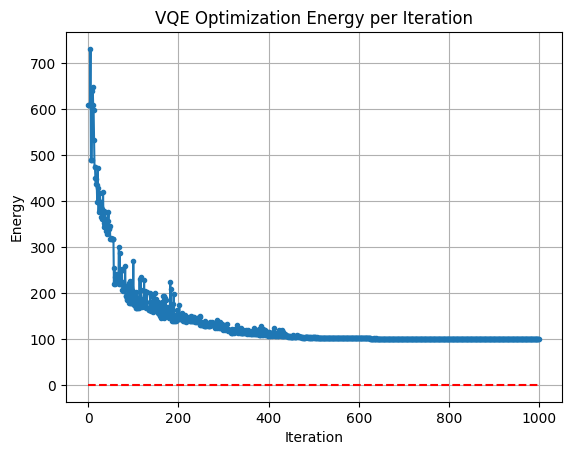

ITERATION 16 === MUB VQE STATE (mub_idx=4, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 2.0868781770830105
Optimal parameters: [ 1.57947035e+00 -1.03529425e+00  1.98141199e+00  1.54571465e+00
  2.09406858e+00  3.58789419e-01 -3.48697363e-02  6.28757280e-01
  1.02305349e-03 -1.34987126e-02  1.24538533e-03  9.00066263e-03
 -4.58294737e-01  1.15881469e+00  1.43353609e-03  9.37773338e-01
  3.76005726e-01  1.61047019e+00  2.66685478e-01  2.14844619e+00
 -3.21633638e-03  1.27104217e-02 -7.71360619e-02 -1.07672591e-02
  1.12269464e+00  3.16401176e-01  7.57213305e-01  1.01033642e+00
  2.76209554e+00  8.25949284e-01  1.03407972e+00 -9.76920383e-02
  9.72095957e-01  2.32854294e-03 -2.99031930e-03 -1.63102252e-01
  1.06079016e+00  2.58207517e-01  2.67236672e+00  1.50556310e+00
  5.00324384e-01  3.85870780e-01  1.18754295e+00  9.01806855e-01
  1.78148666e-01  2.94233342e+00  7.08027570e-02 -1.47631253e-01
  1.45931518e+00  5.03403491e-01  1.35172236e+00  1.66601696e+00
  8.45205069e-01  

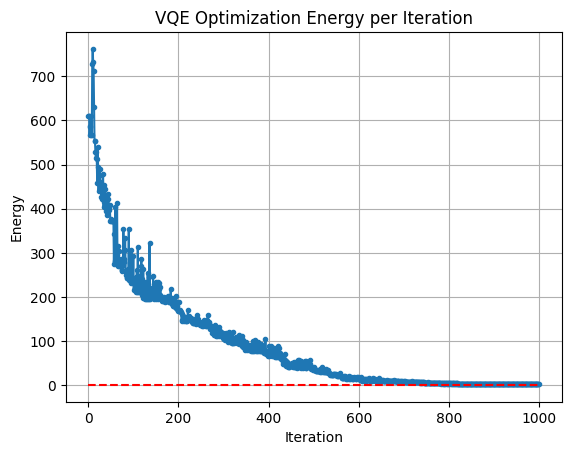

FOUND GLOBAL MINIMUM
ITERATION 17 === MUB VQE STATE (mub_idx=4, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 100.26194735663435
Optimal parameters: [ 1.57884417e-03  3.03440667e+00 -3.80170100e-01  2.76849839e+00
 -6.47364353e-03  3.03539317e+00  1.06252261e+00 -2.65330481e-01
 -2.28322543e-04 -1.78333657e-02  7.08600062e-03  7.30063592e-04
 -7.80209202e-02  1.50157861e+00  5.53180852e-01  1.22697287e+00
  1.74936506e+00  1.02803647e+00  1.23912836e+00  2.46524124e+00
 -6.49014381e-03  3.54267709e-03  8.82085928e-01 -4.68683785e-04
  6.65596338e-01  1.63893179e-01  1.70503794e+00  1.17559880e+00
  1.28927933e+00  9.21435548e-01  1.84259890e+00 -2.33593466e-02
 -8.33863633e-04  8.40615587e-01  5.14451700e-02  2.69733172e-02
  1.32830761e+00 -1.72600254e-01  1.53540386e+00  1.81286910e+00
  6.25284643e-01  1.08405209e+00  4.96839886e-01  5.96709061e-01
 -3.11568087e-04 -3.70565241e-01  2.29987385e+00  5.56394958e-03
  1.57592581e+00  1.13797240e+00 -1.44196172e+00  1.48555153e+

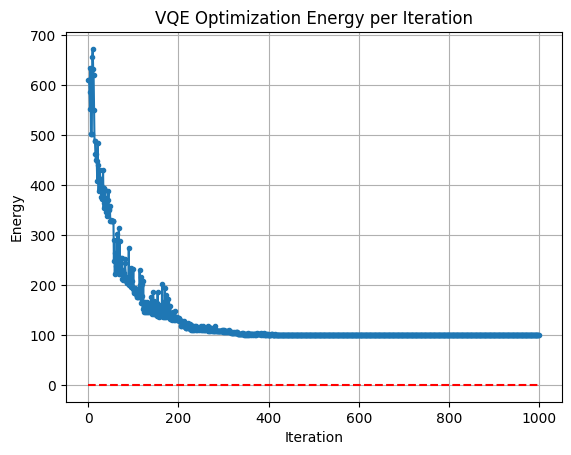

ITERATION 18 === MUB VQE STATE (mub_idx=4, state_idx=2)
NUMBER OF QUBITS 8 8
Ground state energy: 100.95075613558731
Optimal parameters: [ 1.01474564e+00 -1.56943015e+00  6.99670678e-06 -1.07443736e-03
  1.01384578e+00  1.56494536e+00  4.55625646e-01 -5.10765728e-01
  2.11011773e-03  6.63580719e-02  5.50538822e-04 -1.87490994e-04
 -6.92634015e-02  7.33752865e-01  5.01158736e-01  1.49026109e+00
  1.36241898e+00  9.67388478e-01  1.91634486e+00  1.70757205e+00
  5.08638479e-03 -3.82413891e-02  1.51660872e+00  1.84653397e-03
  1.48312217e+00  6.06371345e-01  4.13873661e-01  1.51760897e+00
  1.74735979e+00  5.92613143e-01  1.58290125e+00  6.68512512e-01
  3.00002594e-03  2.68535994e+00 -3.37142394e-02 -1.47306103e-02
  8.37235801e-01  3.00424023e-02  1.55982403e+00  1.13575266e+00
  4.28903683e-01  8.76440868e-01  9.62706953e-01  5.43454601e-01
  8.49110054e-03  8.16380517e-01  1.44189304e+00 -6.64882197e-03
  1.57098965e+00  1.60520474e-01 -8.61718961e-01  1.05377203e+00
 -3.54672254e-01  

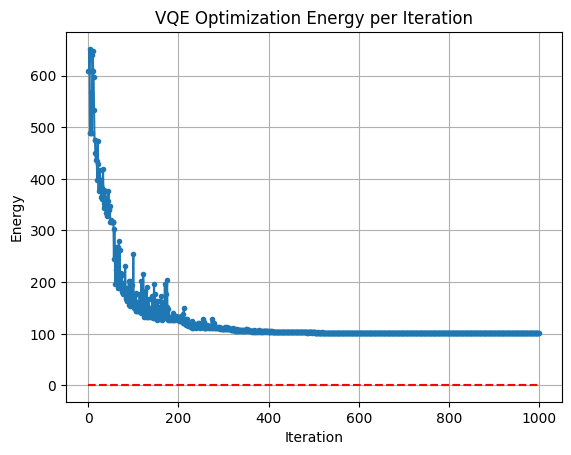

ITERATION 19 === MUB VQE STATE (mub_idx=4, state_idx=3)
NUMBER OF QUBITS 8 8
Ground state energy: 100.70414715311021
Optimal parameters: [ 3.13939689e+00 -2.89342505e-01 -1.43911827e-01  3.04516358e+00
  3.14324071e+00  3.43212179e+00 -6.78064163e-01 -4.60368605e-01
  2.53235462e-03 -1.76210434e-02 -5.70813617e-05  5.00039796e-05
  3.53334074e-03  1.41755882e+00  2.08079256e+00  1.67311258e+00
  1.25872371e+00  5.51764046e-01  1.41789374e+00  1.93074773e+00
  1.52018732e-02  1.77978097e-02  1.57695790e+00  1.48239526e-03
  1.33756030e+00  3.98754446e-01  1.83911416e-01  8.19106015e-01
  1.95820889e+00  1.32523903e-01  1.87277801e+00 -4.05228101e-02
 -4.44771512e-03  1.90290314e+00  6.67656415e-03  1.00986985e-02
  1.30378329e+00 -2.80656215e-01  1.45234001e+00  1.41714226e+00
  7.95496122e-01  3.90883989e-01  7.14742523e-01  7.49316062e-01
  1.81978943e-02  2.98966877e-01  1.56814379e+00  6.63243265e-06
  1.57003358e+00  3.20962775e-01  1.44811544e+00  8.57983164e-01
  6.61546751e-02  

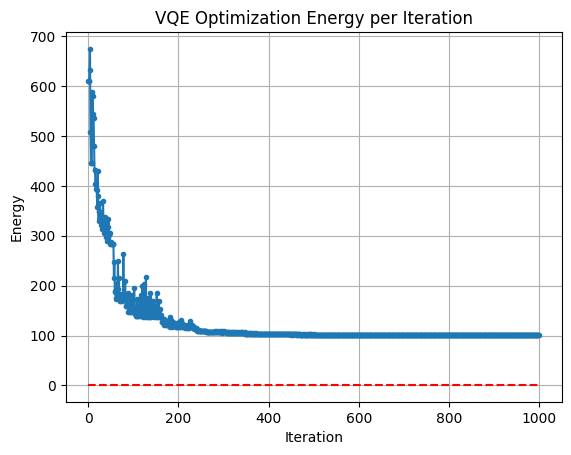

===== SUCCESS RATE FOR GLOBAL MINIMUM 9/20=45.0%


(9, 20)

In [10]:
from experiment_utils import *

run_VQE_MUB_for_all_mubs_on_first_2q(H_total_JSP, min_eigenvalue.real)

ITERATION 0 === MUB VQE STATE on (np.int64(0), np.int64(1))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.92520307e-01  8.40127729e-01  1.07721313e-01
  1.45802182e+00  1.6948

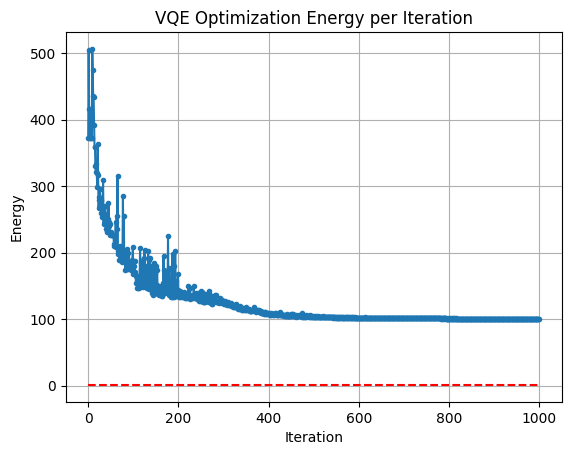

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

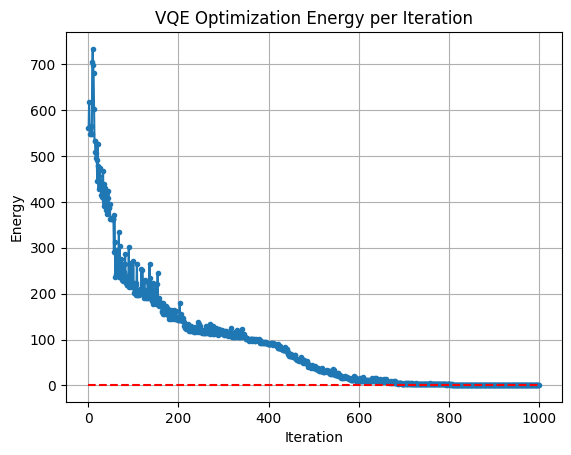

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

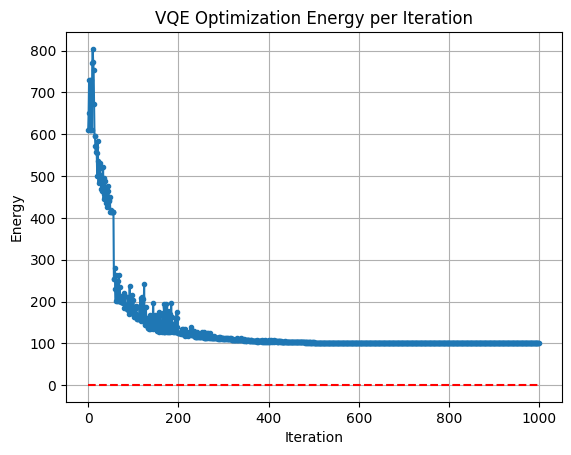

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

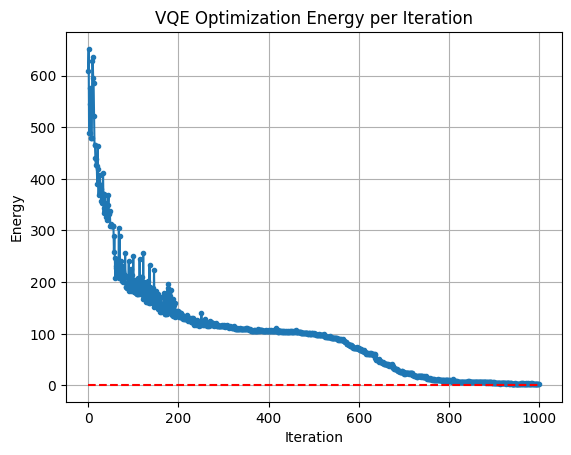

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 4 === MUB VQE STATE on (np.int64(0), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.

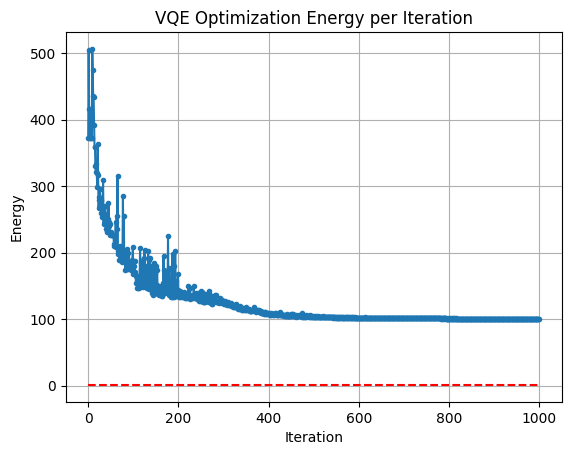

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

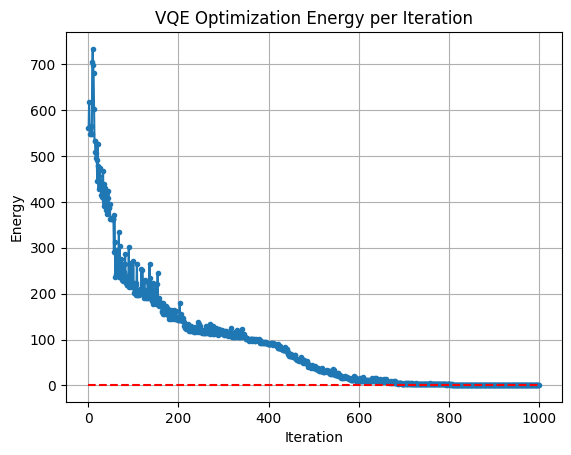

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

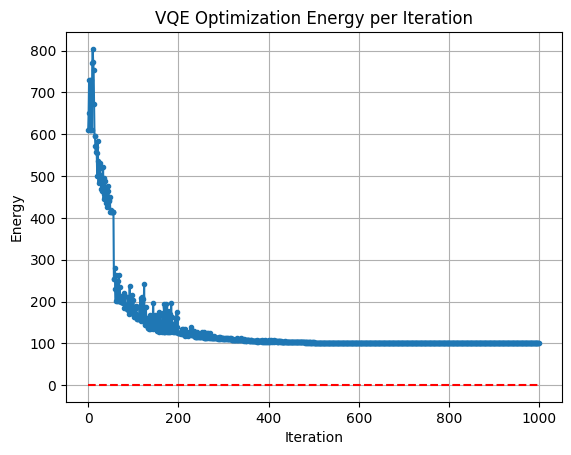

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

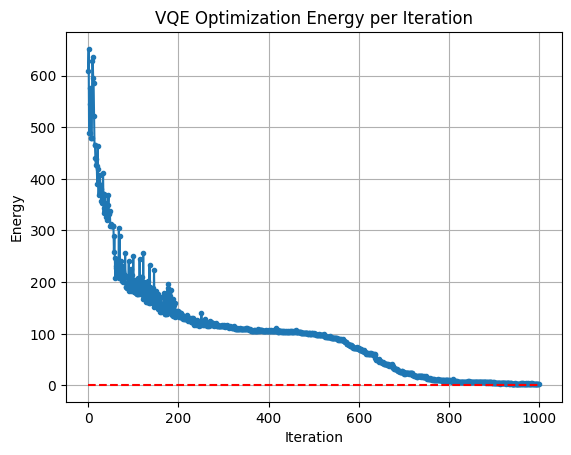

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 8 === MUB VQE STATE on (np.int64(0), np.int64(3))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.

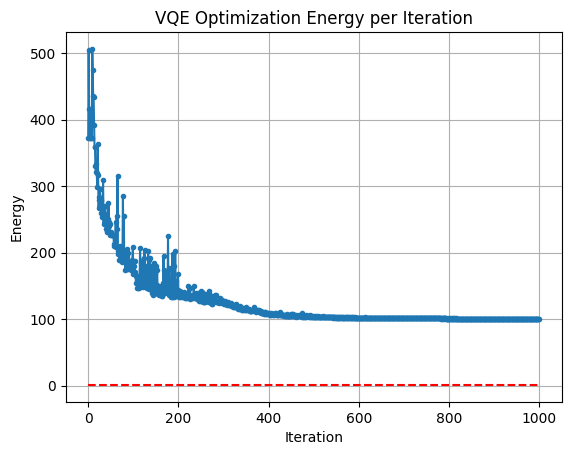

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

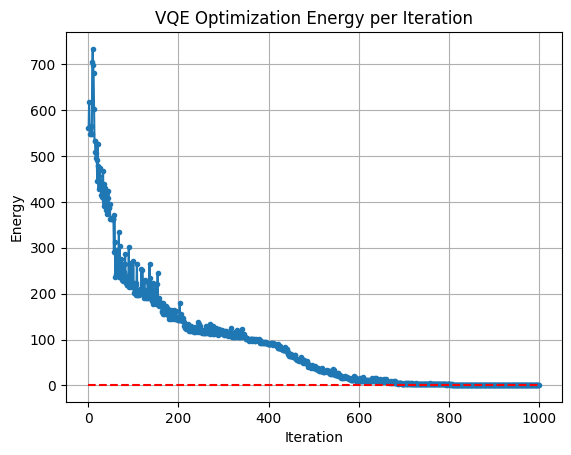

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

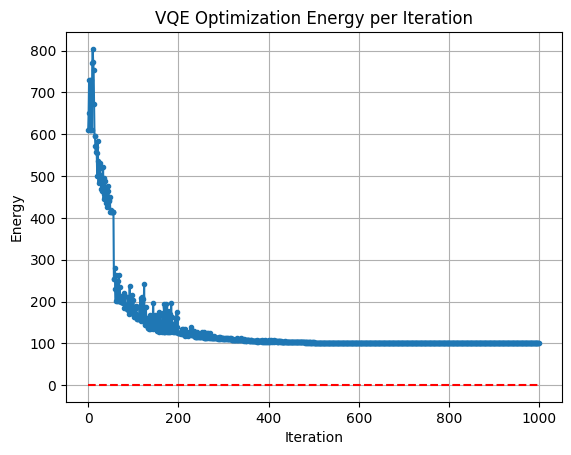

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

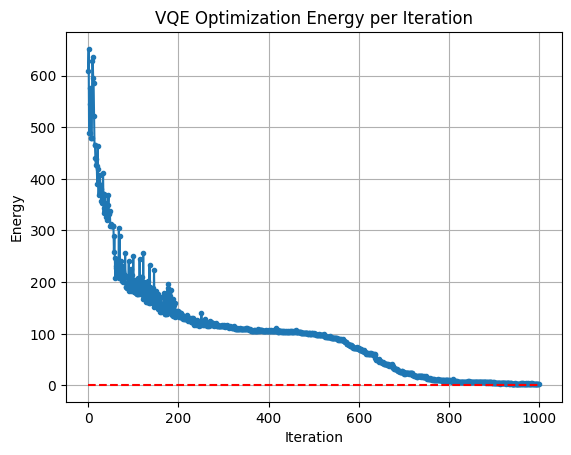

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 12 === MUB VQE STATE on (np.int64(0), np.int64(4))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

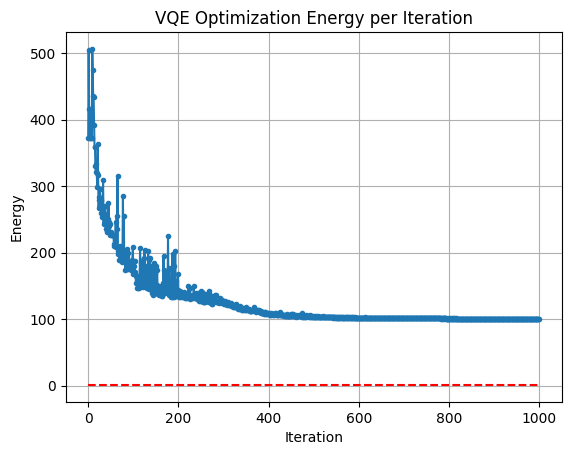

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

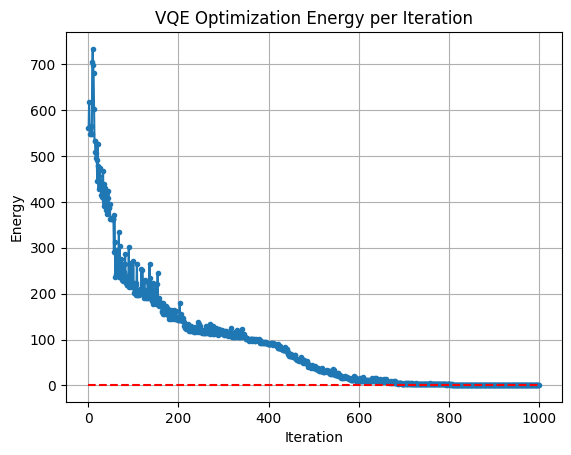

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

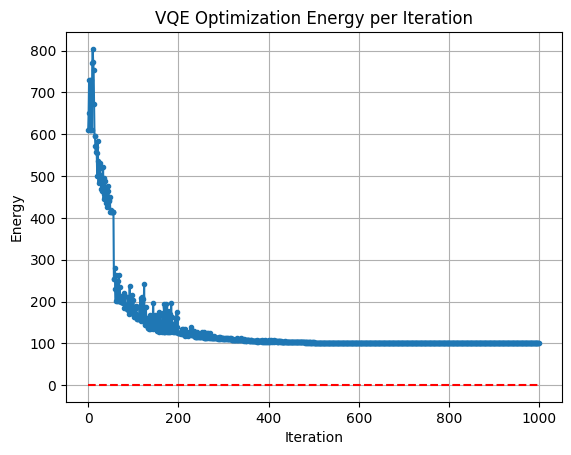

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

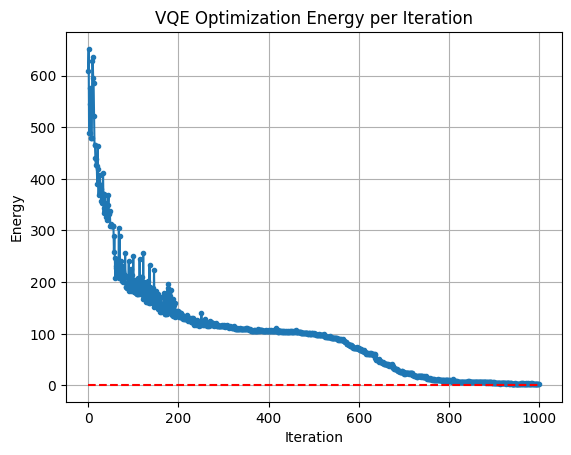

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 16 === MUB VQE STATE on (np.int64(0), np.int64(5))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

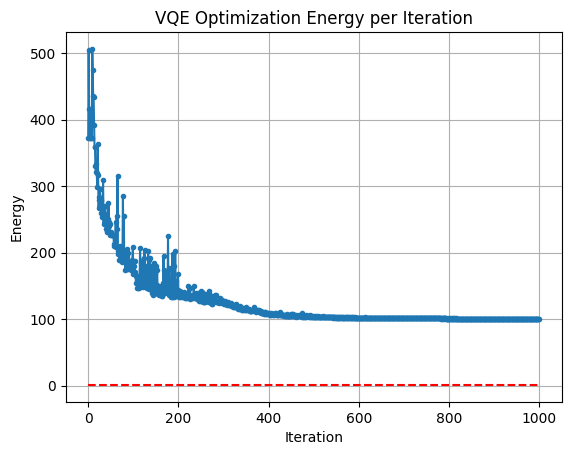

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

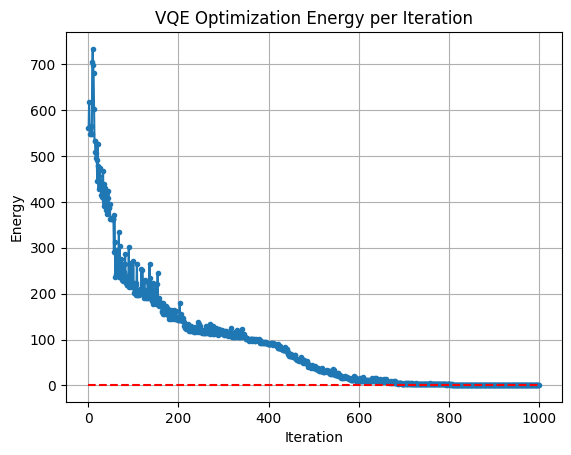

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

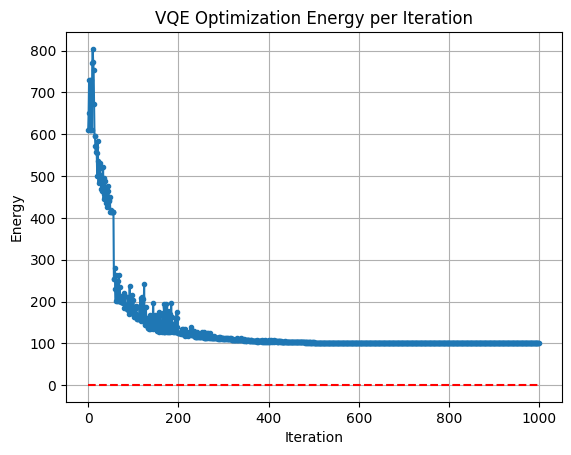

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

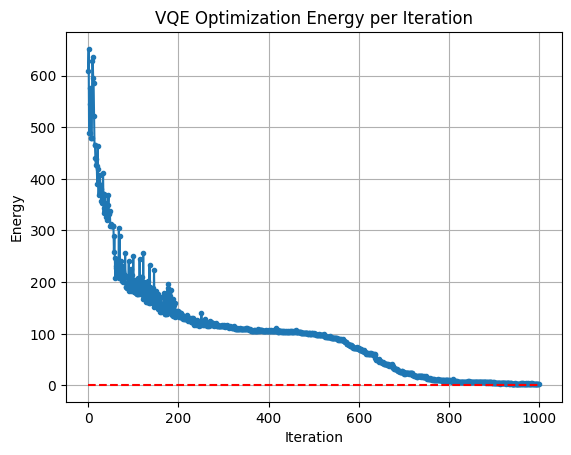

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 20 === MUB VQE STATE on (np.int64(0), np.int64(6))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

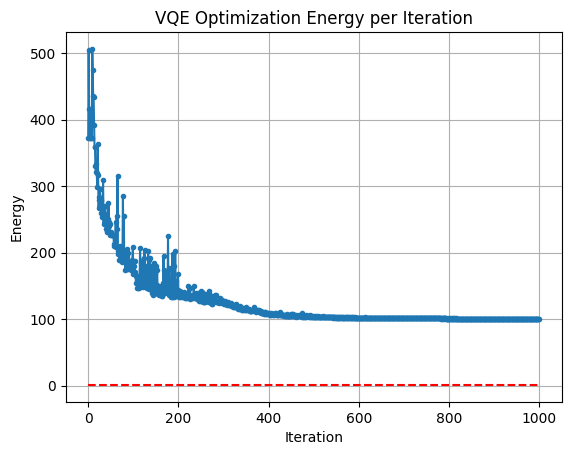

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

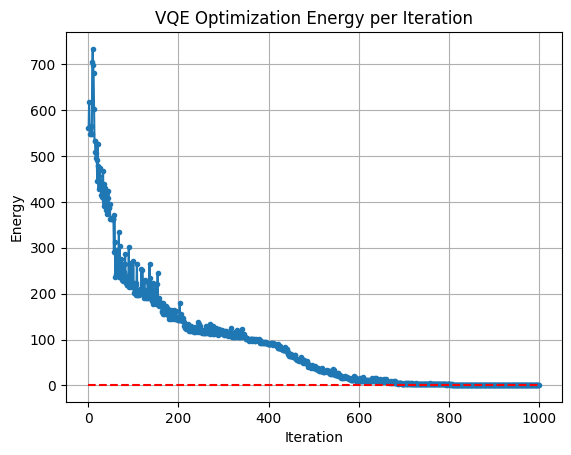

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

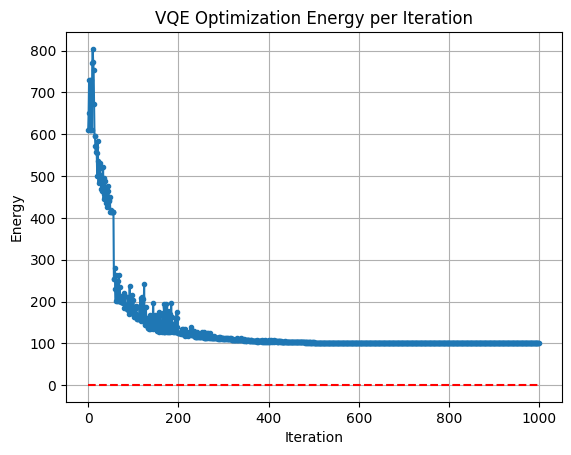

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

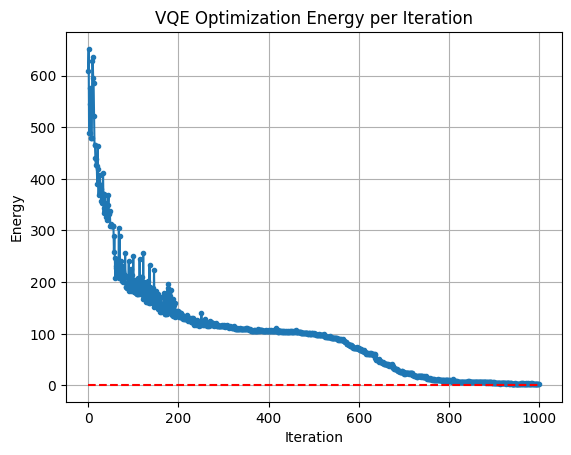

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 24 === MUB VQE STATE on (np.int64(0), np.int64(7))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

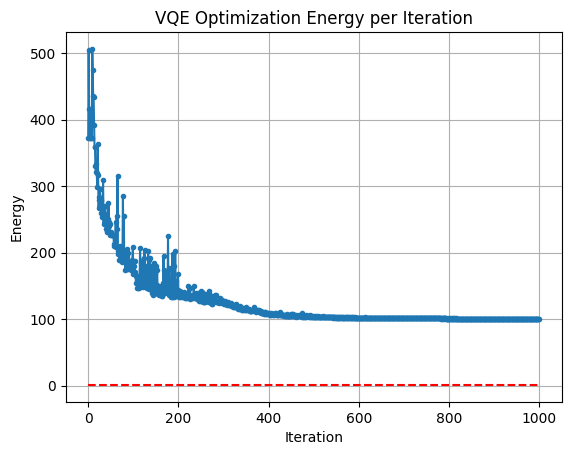

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

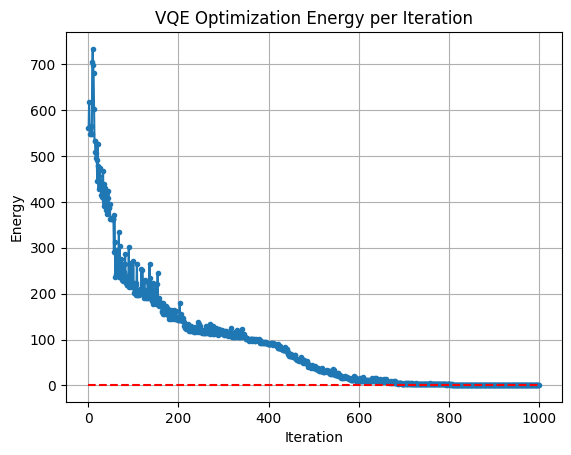

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

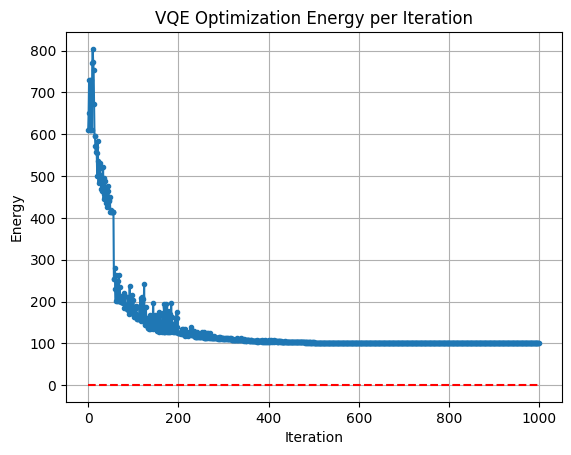

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

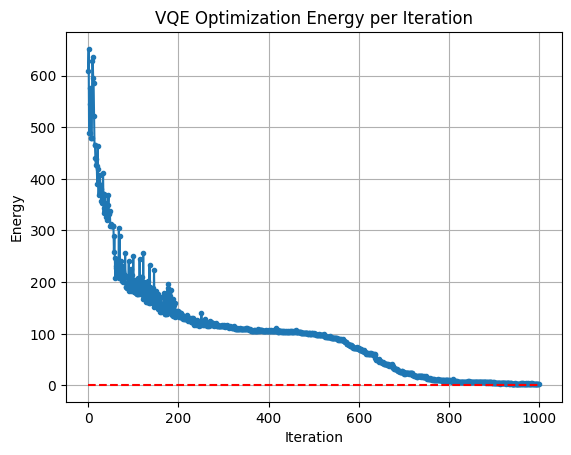

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 28 === MUB VQE STATE on (np.int64(1), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

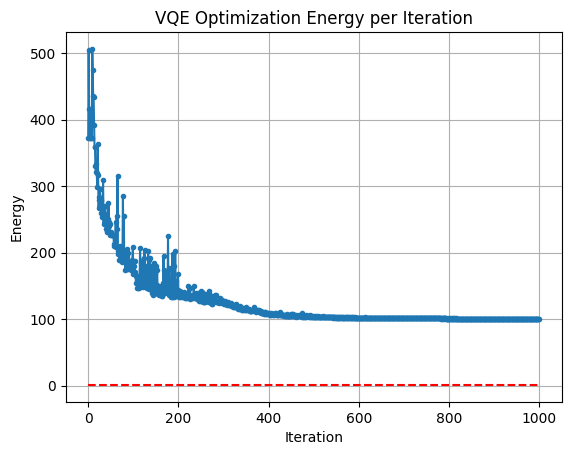

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

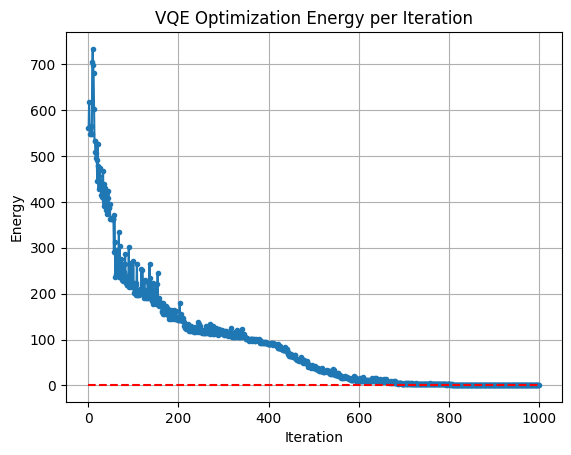

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

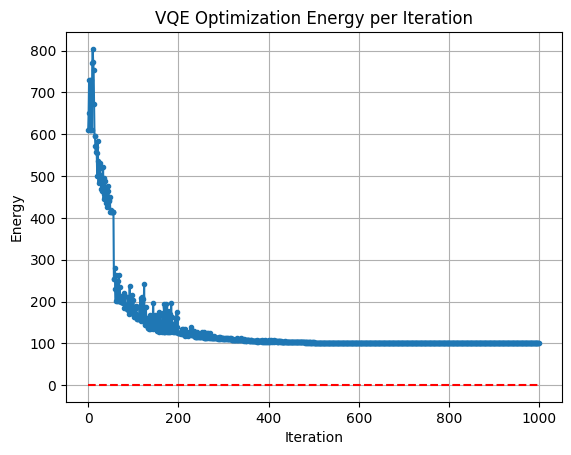

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

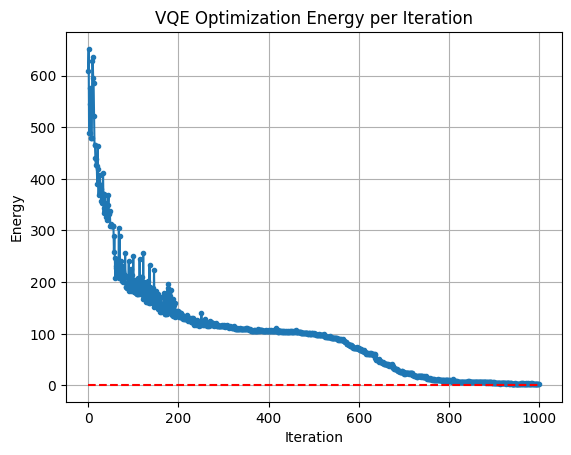

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
===== TOTAL SUCCESS RATE FOR GLOBAL MINIMUM 16/32=50.0%


(16, 32)

In [11]:
run_VQE_MUB_for_all_choose_2q(H_total_JSP, min_eigenvalue.real, 30, list(itertools.product(range(2), range(2))))

In [1]:
# from experiment_utils import *
# from qiskit_aer import Aer

# #Test that this is the MUB state:
# ansatz, thetas = get_mub_ansatz_and_thetas(8, state_idx=1, mub_idx=4, MUB_mask=None)

# qc = ansatz.assign_parameters(thetas)
# print(qc)
#print(parameter_dict_to_list(thetas, ansatz))
##

# # Simulate the circuit
# # backend = Aer.get_backend('statevector_simulator')
# # job = backend.run(qc)
# # result = job.result()
# # statevector = result.get_statevector()

In [2]:
# def vector_to_spherical_angles(v):
#     # Ensure the input is a numpy array and normalized
#     v = np.asarray(v)
#     assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
#     n = len(v)
#     angles = np.zeros(n - 1)

#     # Calculate the angles
#     for i in range(0, n - 1):
#         # Calculate the angle theta_i
#         # Use the norm of the remaining dimensions
#         norm_remaining = np.linalg.norm(v[i+1:])
#         angles[i] = np.arctan2(norm_remaining, v[i])
    
#     return angles

# def spherical_angles_to_vector(angles):
#     # Ensure the input is a numpy array
#     angles = np.asarray(angles)
#     n = len(angles) + 1  # Number of dimensions
    
#     # Initialize the unit vector
#     v = np.zeros(n)
    
#     # Calculate the first coordinate
#     v[0] = np.cos(angles[0])
    
#     # Calculate the remaining coordinates
#     for i in range(1, n):
#         # Compute the product of sines for the previous angles
#         if i < n - 1:
#             sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
#             v[i] = sin_product * np.cos(angles[i])
#         else:
#             # For the last coordinate, we use the product of sines for all previous angles
#             v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

#     return v

# test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
# print(vector_to_spherical_angles(test_v))
# print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

# def get_directions(v, step_size):
#     # Ensure the input is a numpy array
#     v = np.asarray(v)
#     directions = []
    
#     # Iterate over each element in the vector
#     for i in range(len(v)):
#         # Create a copy of the original vector
#         v_plus = v.copy()
#         v_minus = v.copy()
        
#         # Modify the i-th element
#         v_plus[i] += step_size
#         v_minus[i] -= step_size
        
#         # Append the new vectors to the directions list
#         directions.append(v_plus)
#         directions.append(v_minus)
    
#     return directions

# def optimizer(H, initial_guess, step_size=0.01):
#     best_vector_angles = vector_to_spherical_angles(initial_guess)
#     print(best_vector_angles)
#     best_value = get_eigenvalue_sparse(initial_guess, H)
#     print(best_value)
    
#     for iterations in range(500):
#         #Pick best direction
#         for nearby_step in get_directions(best_vector_angles, step_size):
#             new_value = get_eigenvalue_sparse(spherical_angles_to_vector(nearby_step), H)
#             print("direction")
#             if(best_value > new_value):
#                 best_value = new_value
#                 best_vector_angles = nearby_step
#         print(best_vector_angles)
    
#     return best_value, spherical_angles_to_vector(best_vector_angles)

In [3]:
# from scipy.sparse import diags

# H_diag_sparse = diags(H_diag.reshape(-1,))
# initial = np.zeros(shape=(H_diag.shape[0],))
# initial[0] = 1

# optimizer(H_diag, initial)

In [4]:
# **Quantum Exhaustive Binary Search - QEBS**
# from hamiltonians import get_expectation_value
# from qiskit.quantum_info import Statevector

# state_string = "+" * task.num_qubits

# for i in range(task.num_qubits):
#     #If 0
#     state_string_if_0 = state_string[:i] + "0" + state_string[i+1:]
#     state_if_0 = initialize_state_from_string(state_string_if_0)
#     #If 1
#     state_string_if_1 = state_string[:i] + "1" + state_string[i+1:]
#     state_if_1 = initialize_state_from_string(state_string_if_1)
#     print(get_expectation_value(state_if_0, H_total_JSP), get_expectation_value(state_if_1, H_total_JSP))
#     if get_expectation_value(state_if_0, H_total_JSP) >= get_expectation_value(state_if_1, H_total_JSP):
#         state_string = state_string_if_1
#     else:
#         state_string = state_string_if_0

# final_state = initialize_state_from_string(state_string)

# print("Naive solution", state_string)

In [ ]:
# **Simulated Annealing binary search**
# def simulated_annealing_binary_search(hamiltonian, n, max_iterations, debug=True):
#     # Initialize an empty prefix and a dictionary to track prefixes and their values
#     prefixes = {"":1}
#     best_solution = None
#     best_solution_value = 1e9

#     average_value = get_expectation_value(initialize_state_from_string("+" * n), hamiltonian)

#     for _ in range(max_iterations):
#         if len(prefixes) == 0:
#             break

#         # Sample a prefix with probability proportional to exp(-value(prefix))
#         total_value = sum(np.exp(-value / average_value) for value in prefixes.values())
#         probabilities = [np.exp(-value / average_value) / total_value for value in prefixes.values()]
        
#         # Sample a prefix based on the calculated probabilities
#         sampled_prefix = np.random.choice(list(prefixes.keys()), p=probabilities)
#         print(f"Sampled {sampled_prefix}") if debug else None
#         del prefixes[sampled_prefix]

#         # Check the value of adding a '0' to the sampled prefix
#         prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "0"] = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             best_solution = sampled_prefix + "0"
#             print(f"Landed on final state {best_solution}") if debug else None

#         # Check the value of adding a '1' to the sampled prefix
#         prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "1"] = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             best_solution = sampled_prefix + "1"
#             print(f"Landed on final state {best_solution}") if debug else None

#         print(prefixes) if debug else None
#         #print("normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])

#     # Return the most valuable prefix or any other relevant information
#     if best_solution == None or (len(prefixes) > 0 and best_solution_value > min(prefixes.values())):
#         proposed_solution = min(prefixes, key=prefixes.get)
#     else:
#         proposed_solution = best_solution
    

#     if len(proposed_solution) < n:
#         for _ in range(n - len(proposed_solution)):
#             values, keys = np.array(list(prefixes.values())), np.array(list(prefixes.keys()))
#             sampled_prefix = keys[np.argmin(values)]

#             print(f"Greedy Sampled {sampled_prefix}") if debug else None
#             del prefixes[sampled_prefix]

#             # Check the value of adding a '0' to the sampled prefix
#             prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_zero_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "0"] = prefix_with_zero_value
            
#             # Check the value of adding a '1' to the sampled prefix
#             prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_one_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "1"] = prefix_with_one_value

#             if len(sampled_prefix) + 1 == n:
#                 if prefix_with_zero_value < prefix_with_one_value:
#                     return sampled_prefix + "0"
#                 else:
#                     return sampled_prefix + "1"

#             print("Greedy", prefixes) if debug else None
#             #print("Greedy normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])
#     else:
#         return proposed_solution

# print("Found Solution", simulated_annealing_binary_search(H_total_JSP, task.num_qubits, 4))

In [ ]:
#**Benchmark - Probability of success vs number of iterations**
# N_MAX = 20
# iter_nums = list(range(2, 6))
# probabilities = []

# for iter_num in iter_nums:
#     success = 0
#     for N in range(N_MAX):
#         if simulated_annealing_binary_search(H_total_JSP, task.num_qubits, iter_num, debug=False) == binary_solution:
#             success += 1
#     probabilities += [success / N_MAX]

# print(probabilities)
# plt.plot(iter_nums, probabilities, marker='.')
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability of finding the optimal solution")

# plt.show()